In [1]:
import pandas as pd
import numpy as np
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

### Gillespie Results 0301_211649

Here we use 1 meta-clone as an example, showing the basic plotting functions of Gillespie analysis. First, we load the original model and get the cluster names.

In [2]:
import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/clonaltrans/')

path = '../results/CordBloodDynamicRates/model_last.pt'
model = torch.load(path, map_location='cpu')
device = torch.device('cpu')

import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/')

In [3]:
anno = pd.read_csv(os.path.join(
    model.config['data_loader']['args']['data_dir'], 
    model.config['data_loader']['args']['annots']
))
cluster_names = anno['populations'].values[:model.N.shape[2]]

In [4]:
gillespie_dir='./results/CordBloodDynamicGillespie/models/'
gillespie_dir_valid = os.path.join(gillespie_dir, 'clone_12')

#### Visualization of Gillespie trees

One need to specify the `seed` parameter and the path of Gillespie results for a particular clone. Lots of seeds have hundreds even thousands of nodes, so the plot would be messy and the generation time would be slow. You may pick one with fewer nodes for proof of concept purpose.

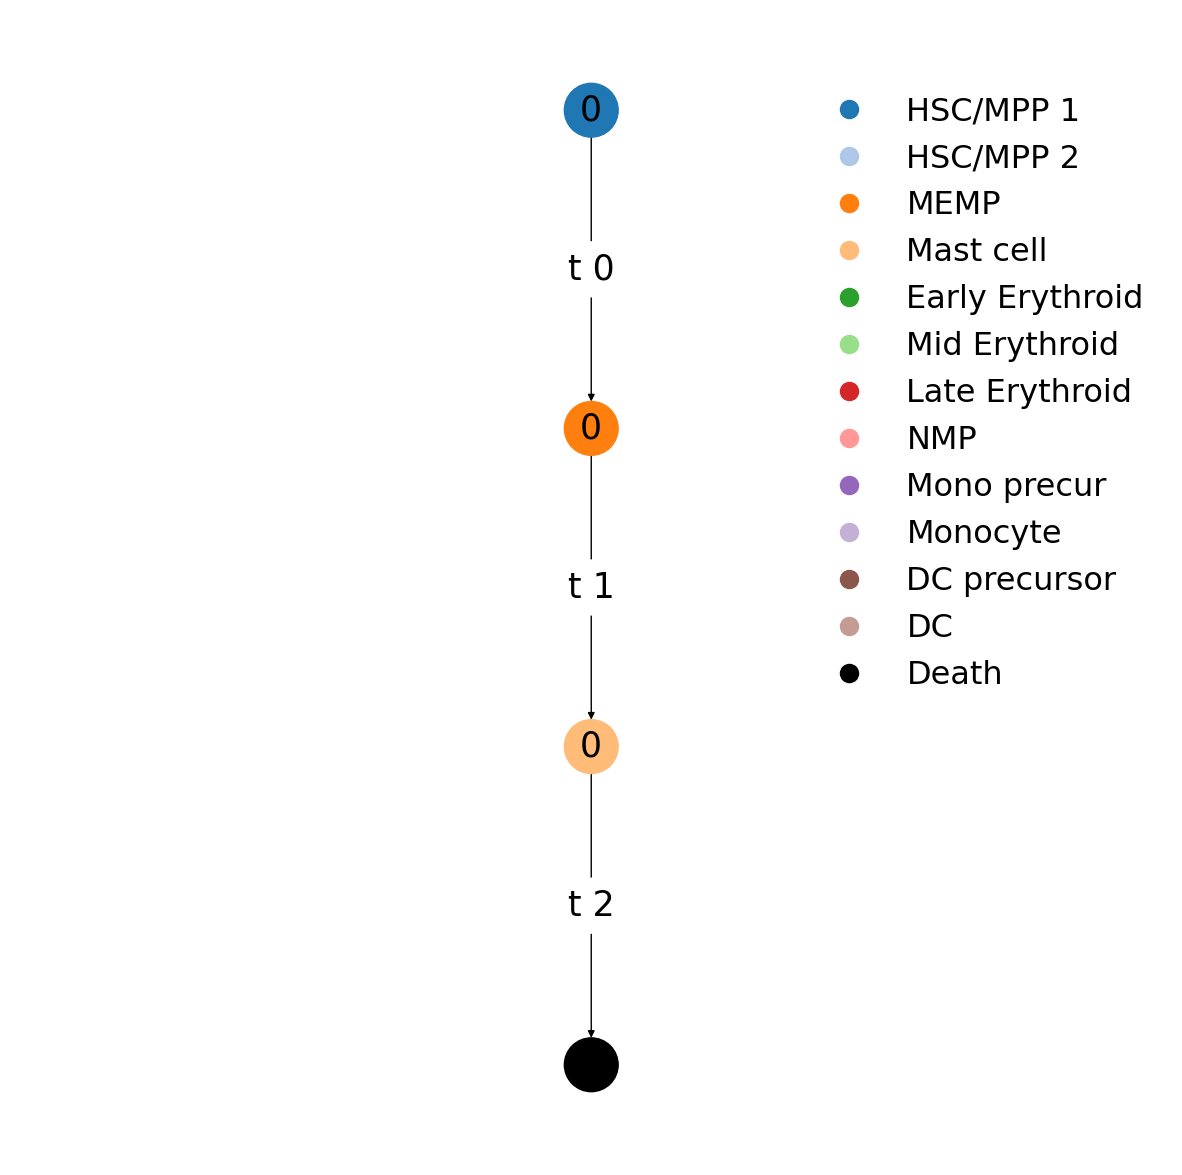

In [5]:
from clonaltrans.pl import visualize_gtree
visualize_gtree(
    39, 
    cluster_names, 
    gillespie_dir=gillespie_dir_valid, 
    show=True
)

#### Number of Divisions to the First Progeny

We get a distribution of divisions for each population within a meta-clone, showing the histogram of number of divisions needed between a HSC and the progeny of a certain child population. So, if we have 15 populations, `visualize_num_div` would create 15 plots.

In [6]:
from clonaltrans.pl import get_num_div
get_num_div(cluster_names, gillespie_dir=gillespie_dir_valid)

Total # of gillespie trials for ['models', 'clone_12']: 999


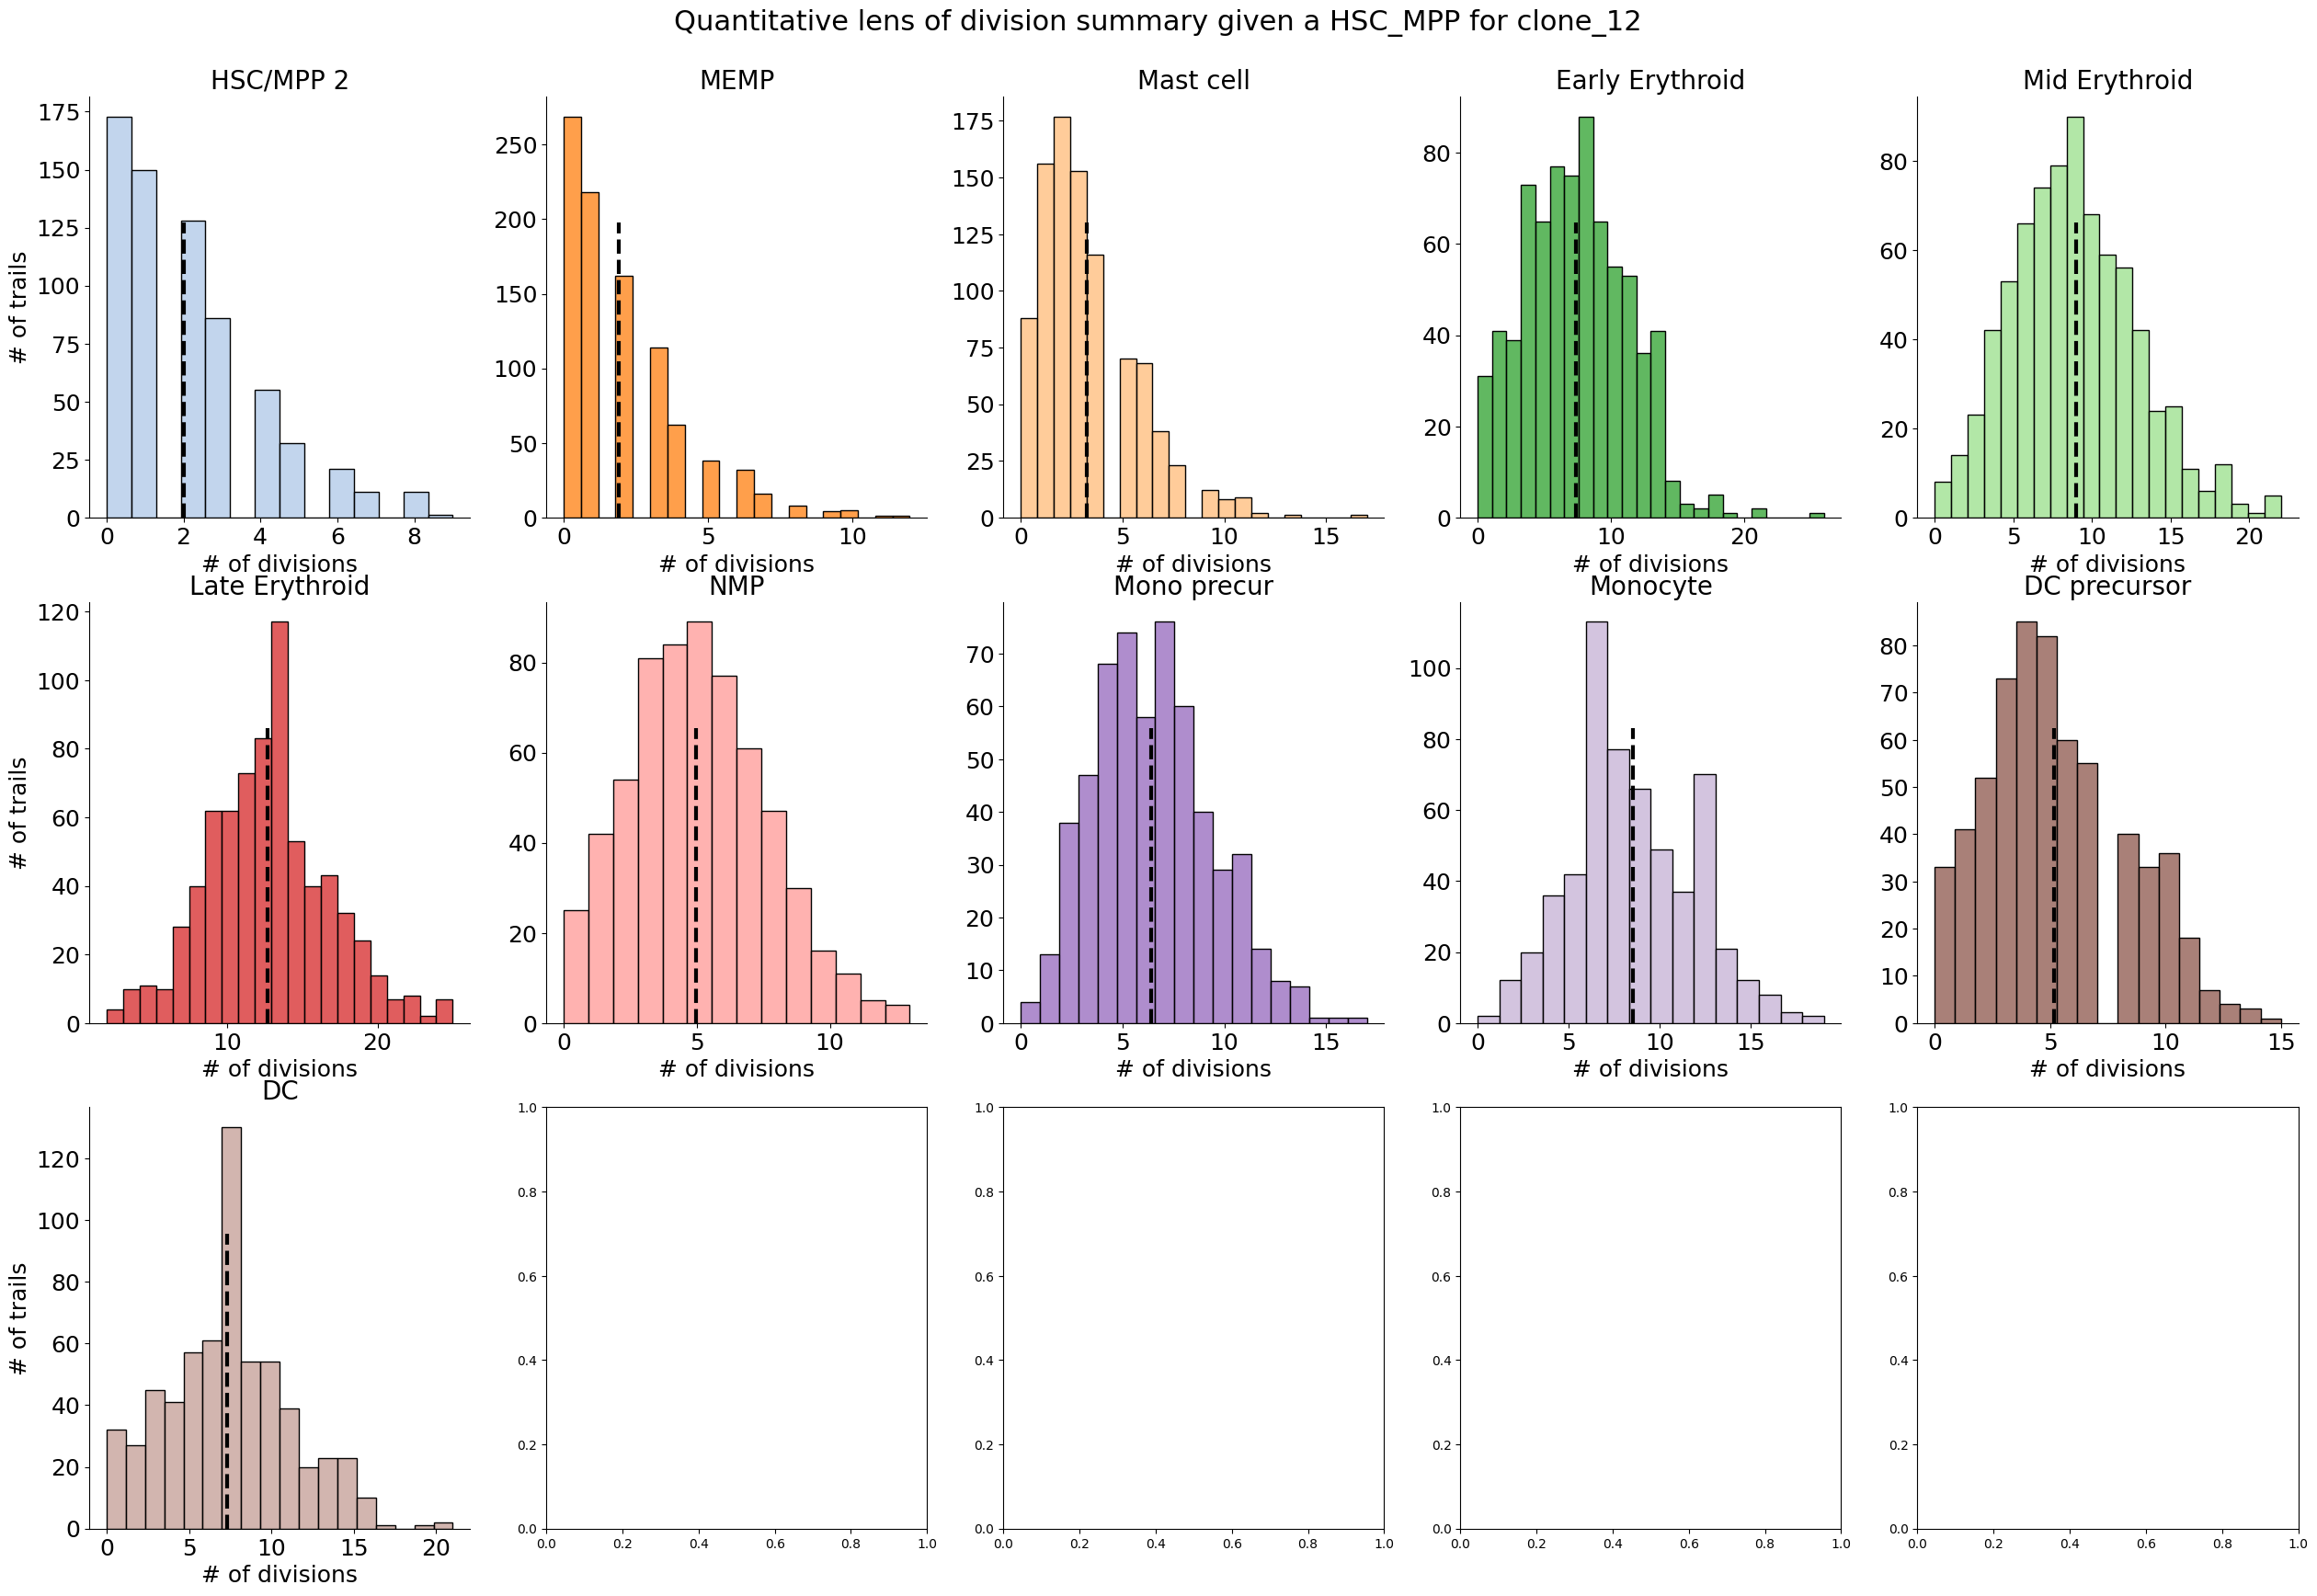

In [7]:
from clonaltrans.pl import visualize_num_div
visualize_num_div(cluster_names, gillespie_dir=gillespie_dir_valid)

#### Same Analysis for all Meta-Clones (Inputs for Statistical Tests)

In [8]:
from clonaltrans.pl import get_num_div
from natsort import natsorted

for directory in natsorted(os.listdir(gillespie_dir)):
    if directory.startswith('clone'):
        gillespie_dir_clones = os.path.join(gillespie_dir, directory)
        get_num_div(cluster_names, gillespie_dir=gillespie_dir_clones)

Total # of gillespie trials for ['models', 'clone_0']: 980
Total # of gillespie trials for ['models', 'clone_1']: 951
Total # of gillespie trials for ['models', 'clone_2']: 970
Total # of gillespie trials for ['models', 'clone_3']: 982
Total # of gillespie trials for ['models', 'clone_4']: 958
Total # of gillespie trials for ['models', 'clone_5']: 946
Total # of gillespie trials for ['models', 'clone_6']: 957
Total # of gillespie trials for ['models', 'clone_7']: 957
Total # of gillespie trials for ['models', 'clone_8']: 954
Total # of gillespie trials for ['models', 'clone_9']: 966
Total # of gillespie trials for ['models', 'clone_10']: 930
Total # of gillespie trials for ['models', 'clone_11']: 927
Total # of gillespie trials for ['models', 'clone_12']: 999


#### Comparison of Divisions between Meta-Clones

Here we produce 3 plots:

- Mean # of divisions needed to produced the first progeny
- Potency preferance of HSCs for each population (# of Gillespie results have the target population)
- Statistical comparison of the distribution of divisions needed 

I've noticed that **multiple test correction method** affects the final results quite a lot.

In [9]:
from clonaltrans.pl import get_div_distribution
import copy

distributions = []
length, mean, num_trails = [], [], []

for clone in range(model.N.shape[1]):
    distribution, counts = get_div_distribution(os.path.join(gillespie_dir, f'clone_{clone}'), cluster_names)
    distributions.append(distribution)
    num_trails.append(counts)

In [10]:
length = copy.deepcopy(distributions)
mean = copy.deepcopy(distributions)

for clone in mean:
    for key in clone.keys():
        clone[key] = np.mean(clone[key]) if len(clone[key]) > 0 else 0

for clone in length:
    for key in clone.keys():
        clone[key] = len(clone[key])

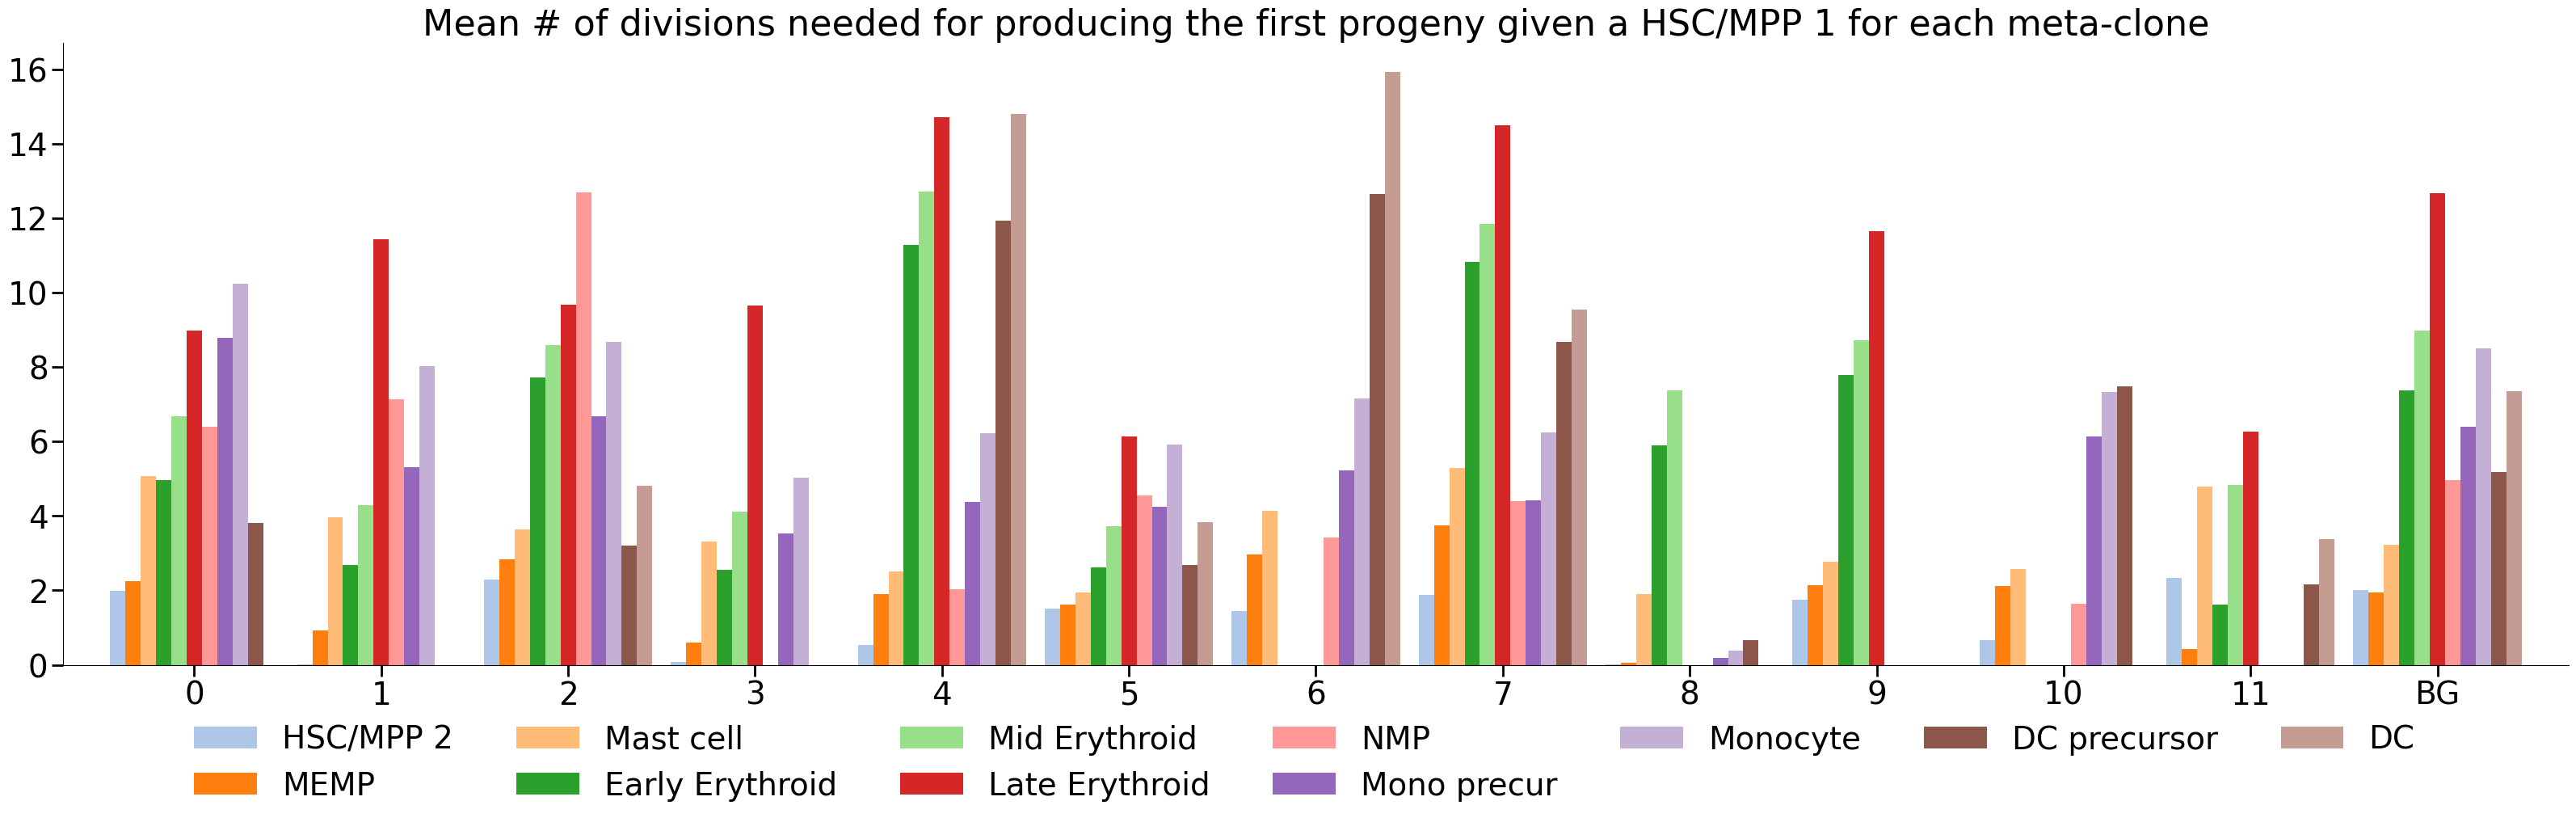

In [11]:
from clonaltrans.pl import mean_division_to_first
mean_division_to_first(mean)

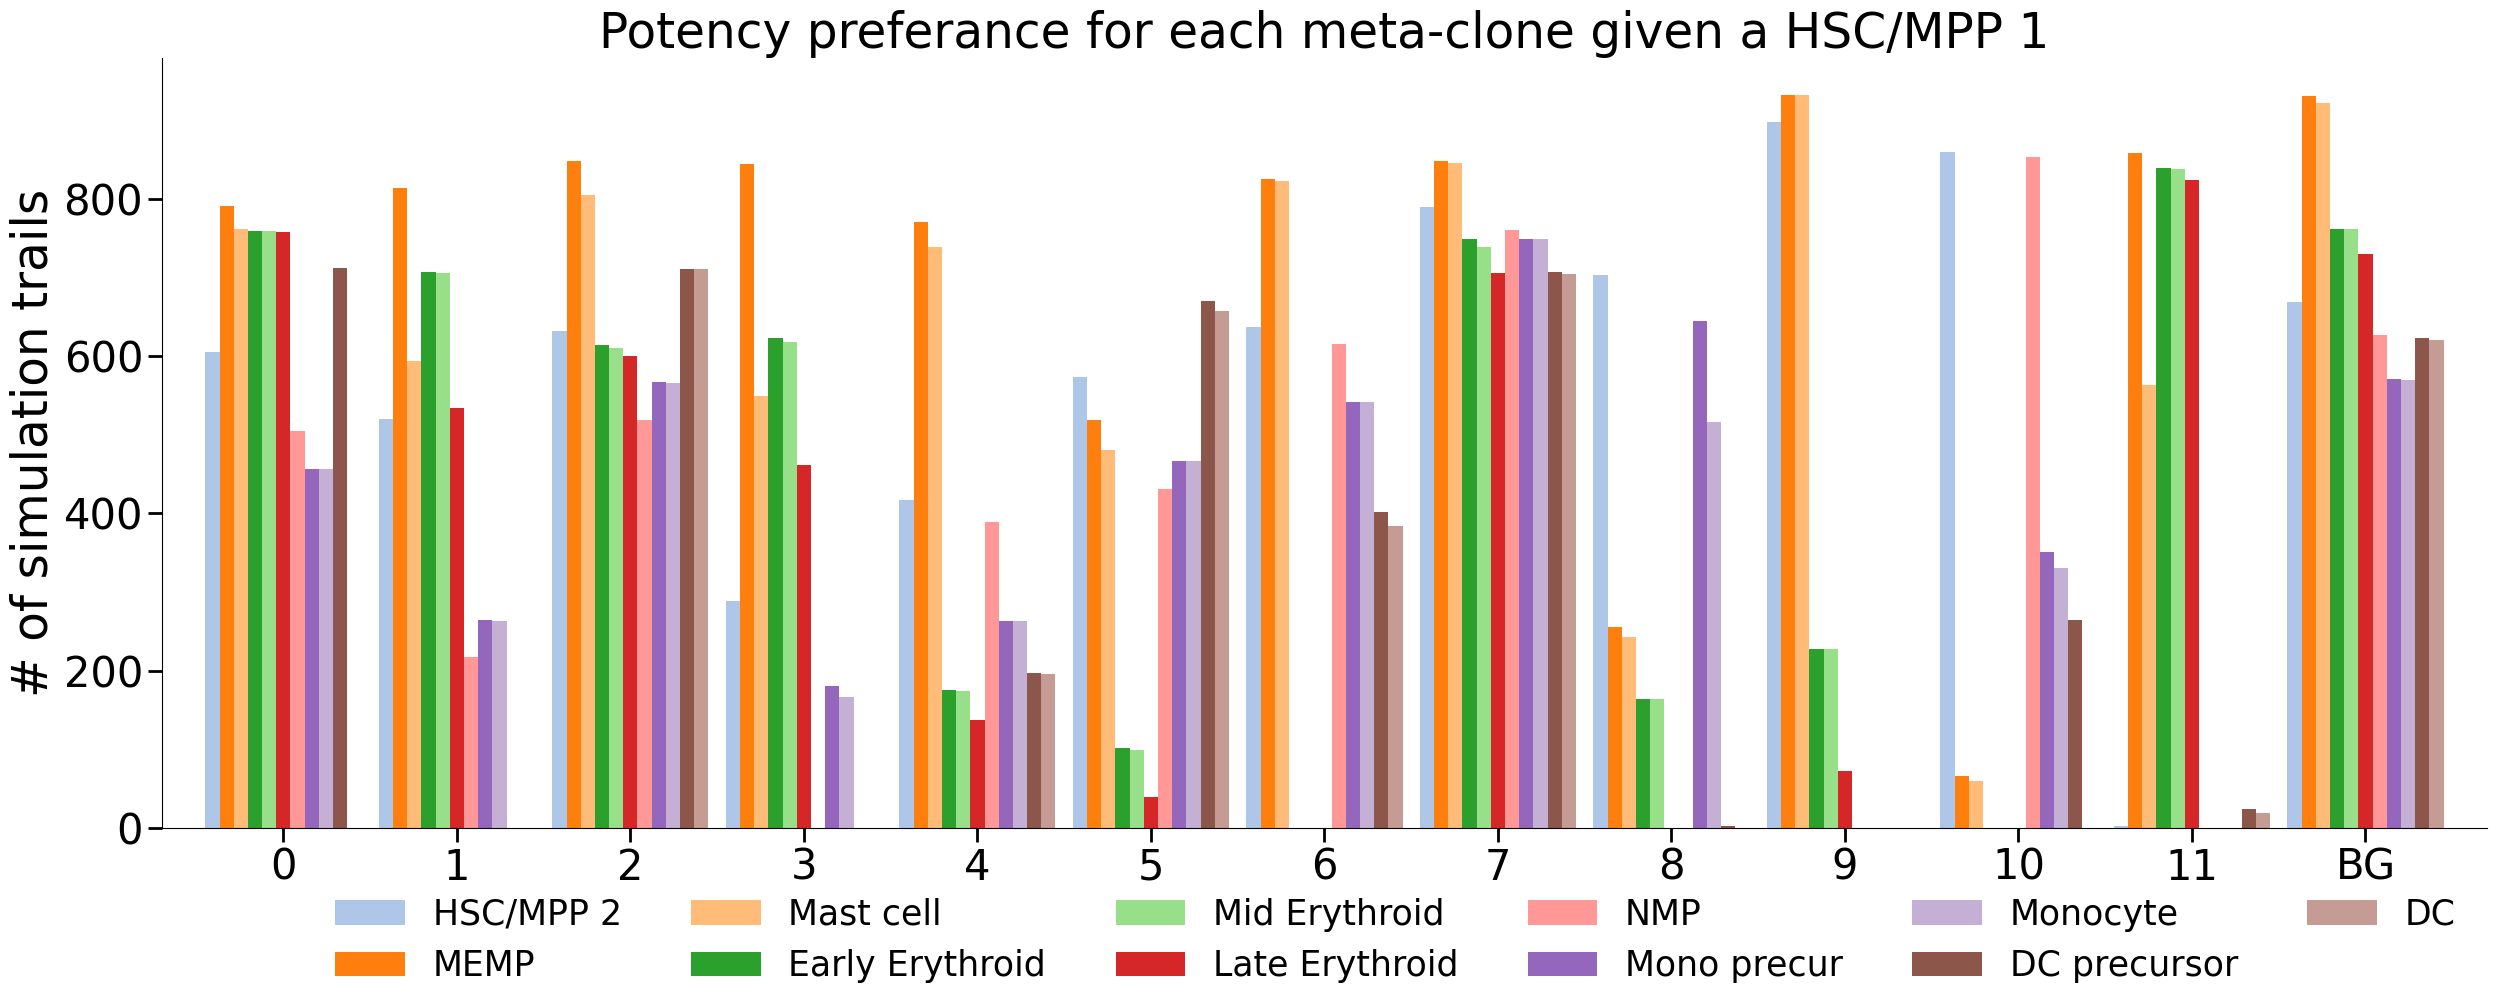

In [12]:
from clonaltrans.pl import succeed_trails_to_first
succeed_trails_to_first(length, num_trails)

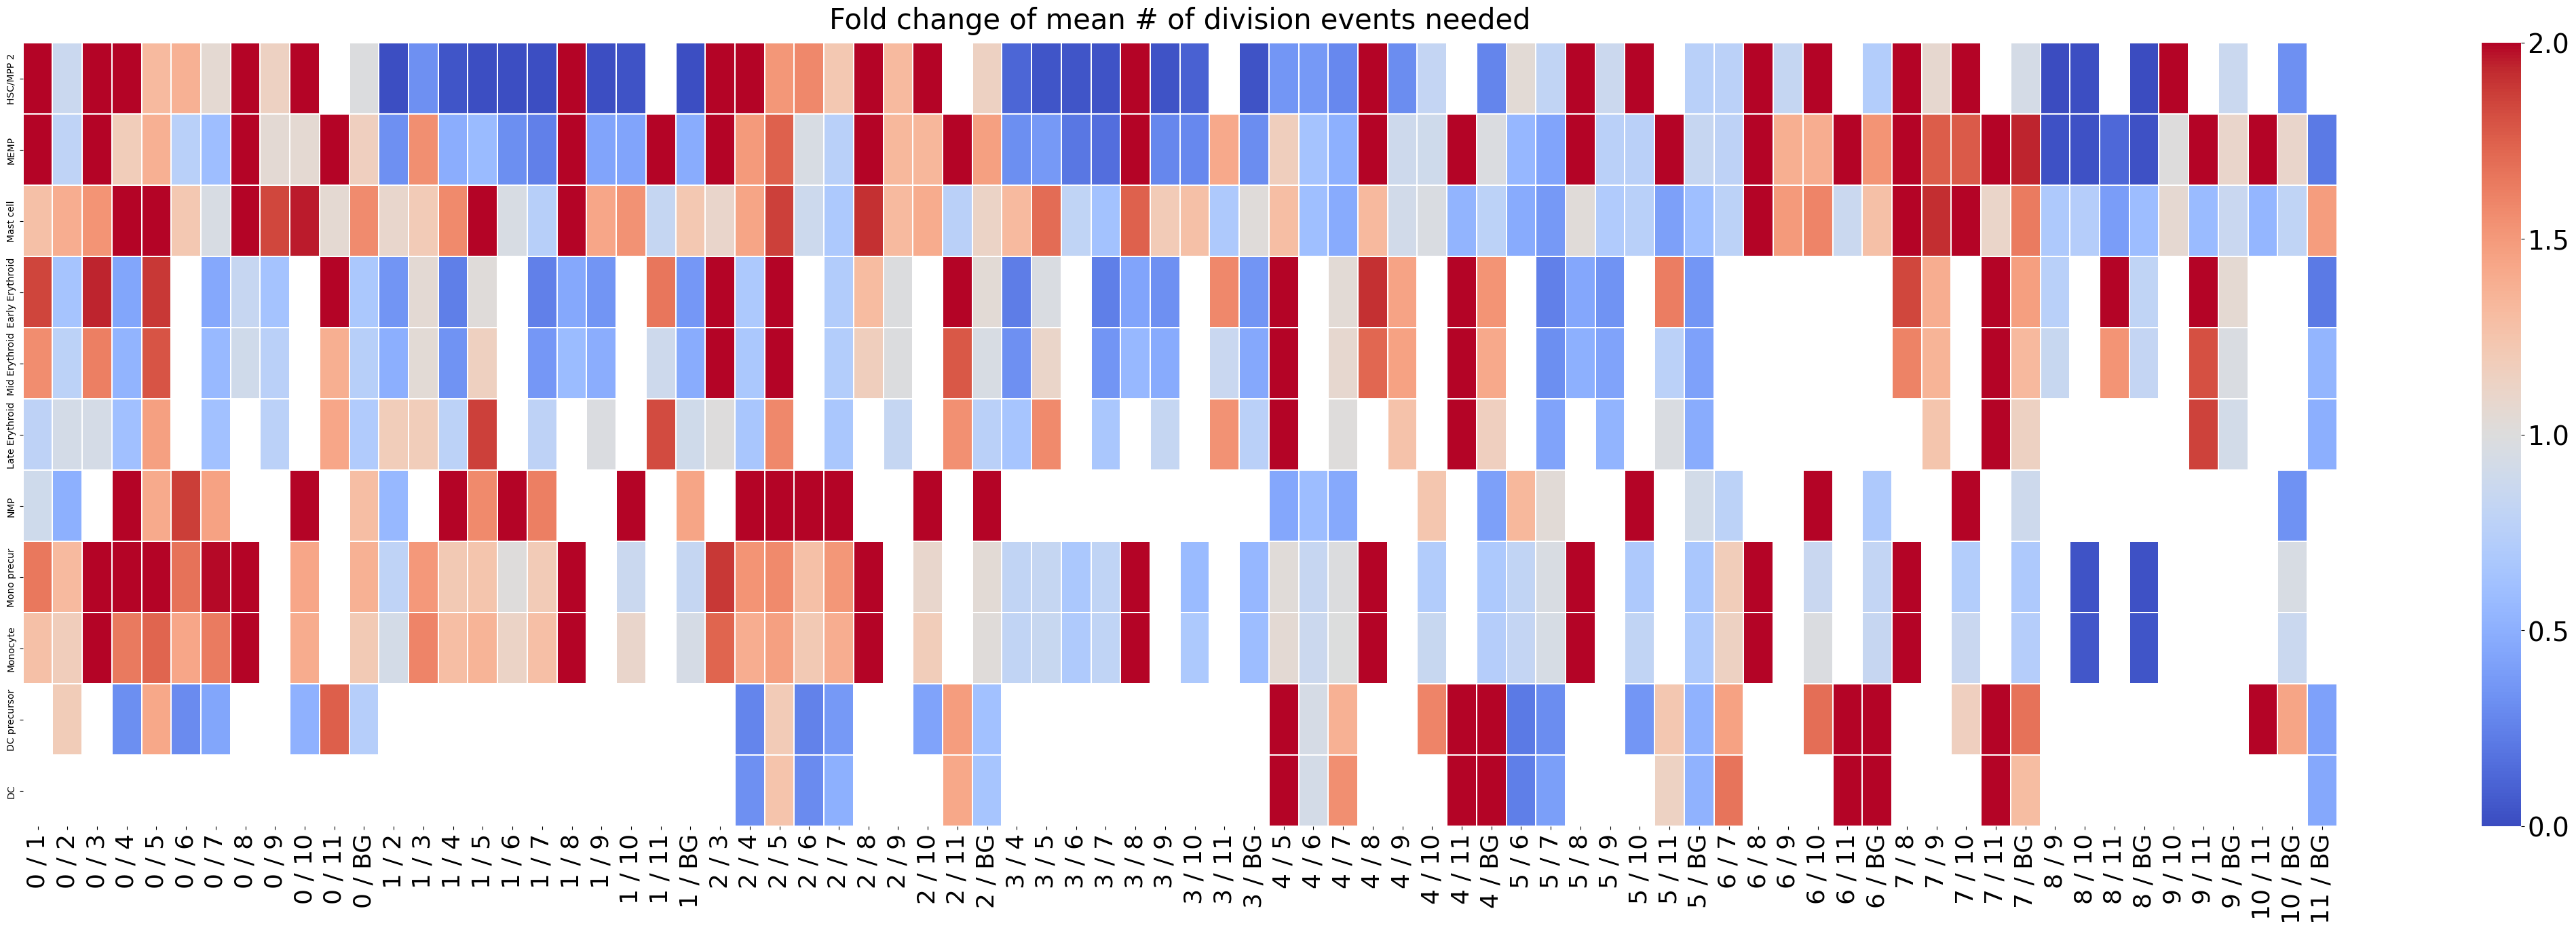

In [18]:
from clonaltrans.pl import clone_dist_diff_plot
clone_dist_diff_plot(distributions, model)

#### Fate Probability Given a Celltype

In [14]:
from natsort import natsorted
from clonaltrans.pl import get_fate_prob

aggre = get_fate_prob(model, cluster_names, gillespie_dir)

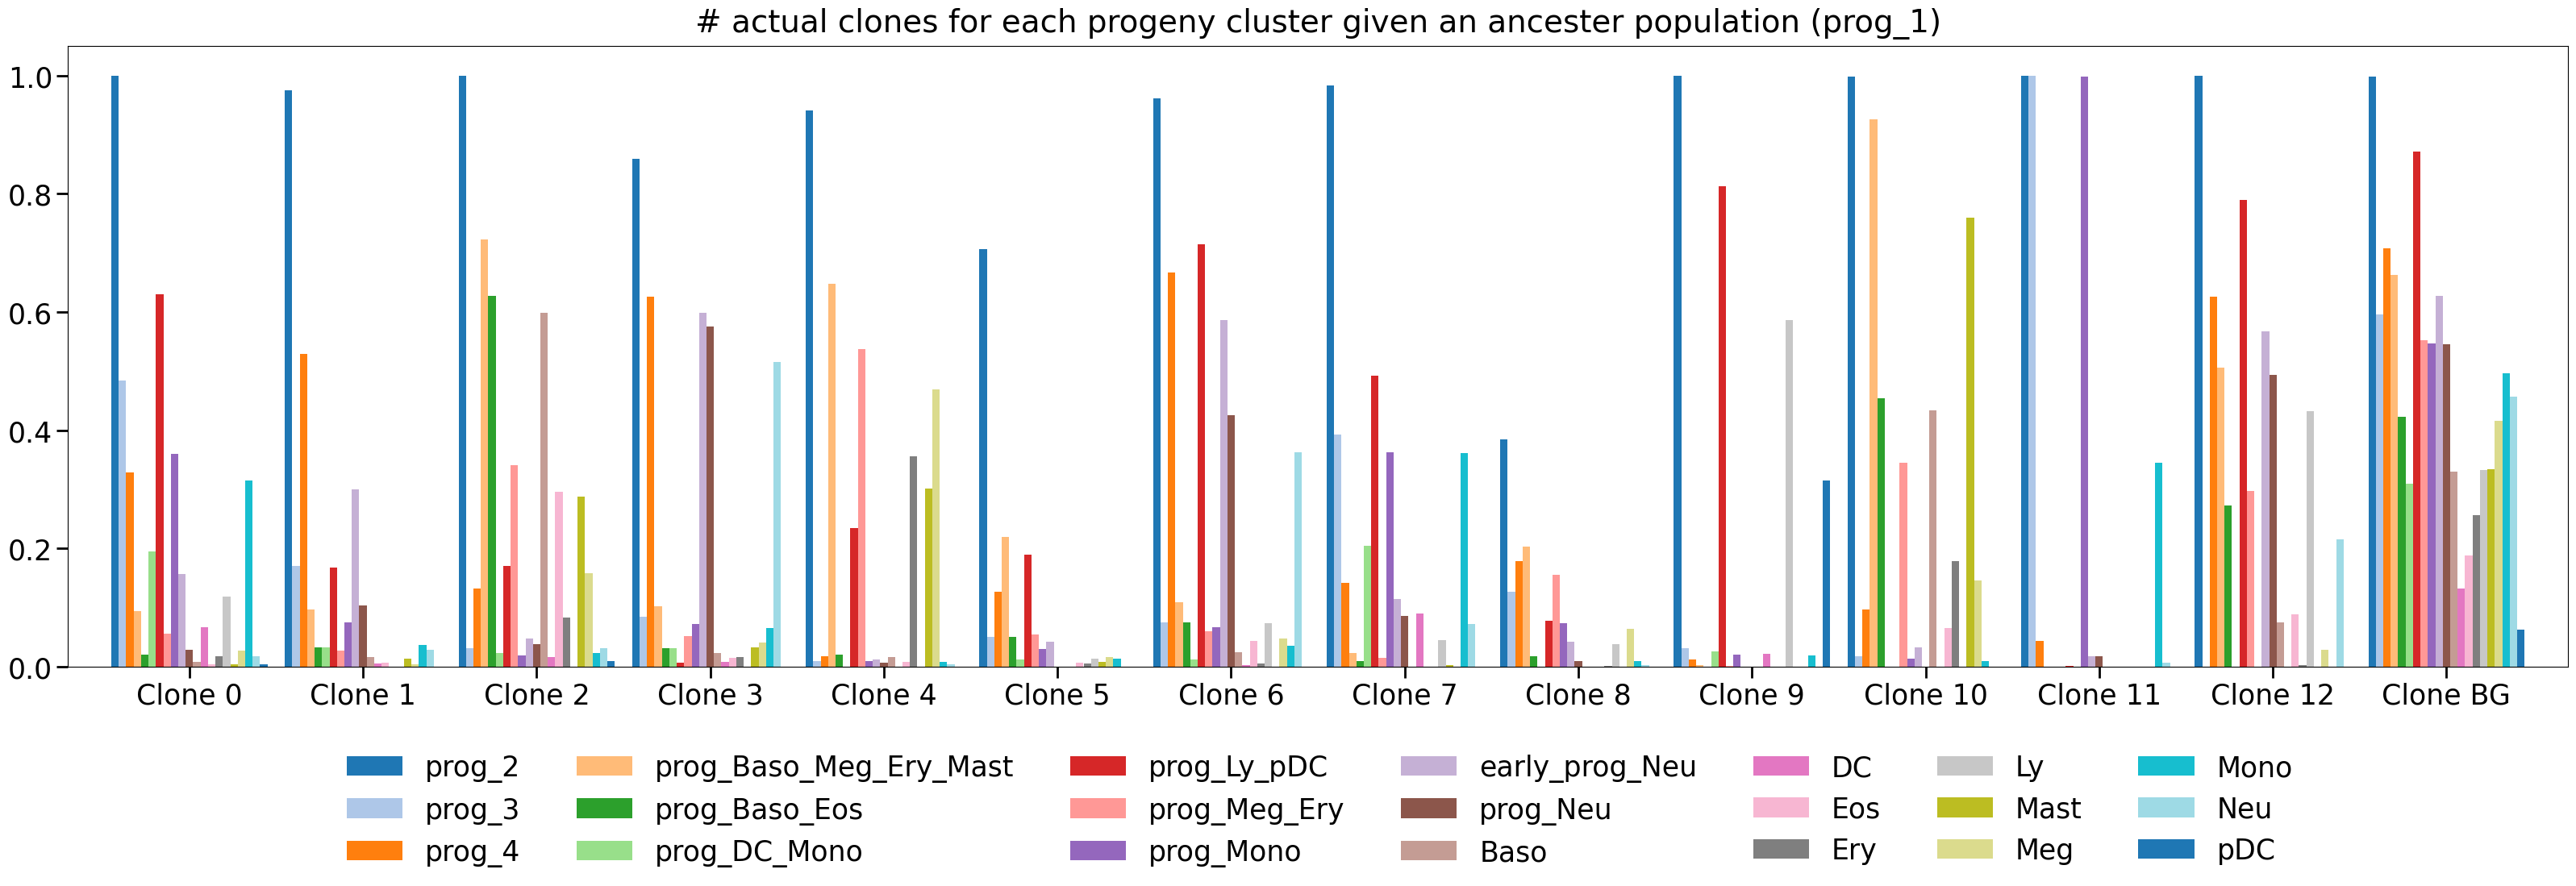

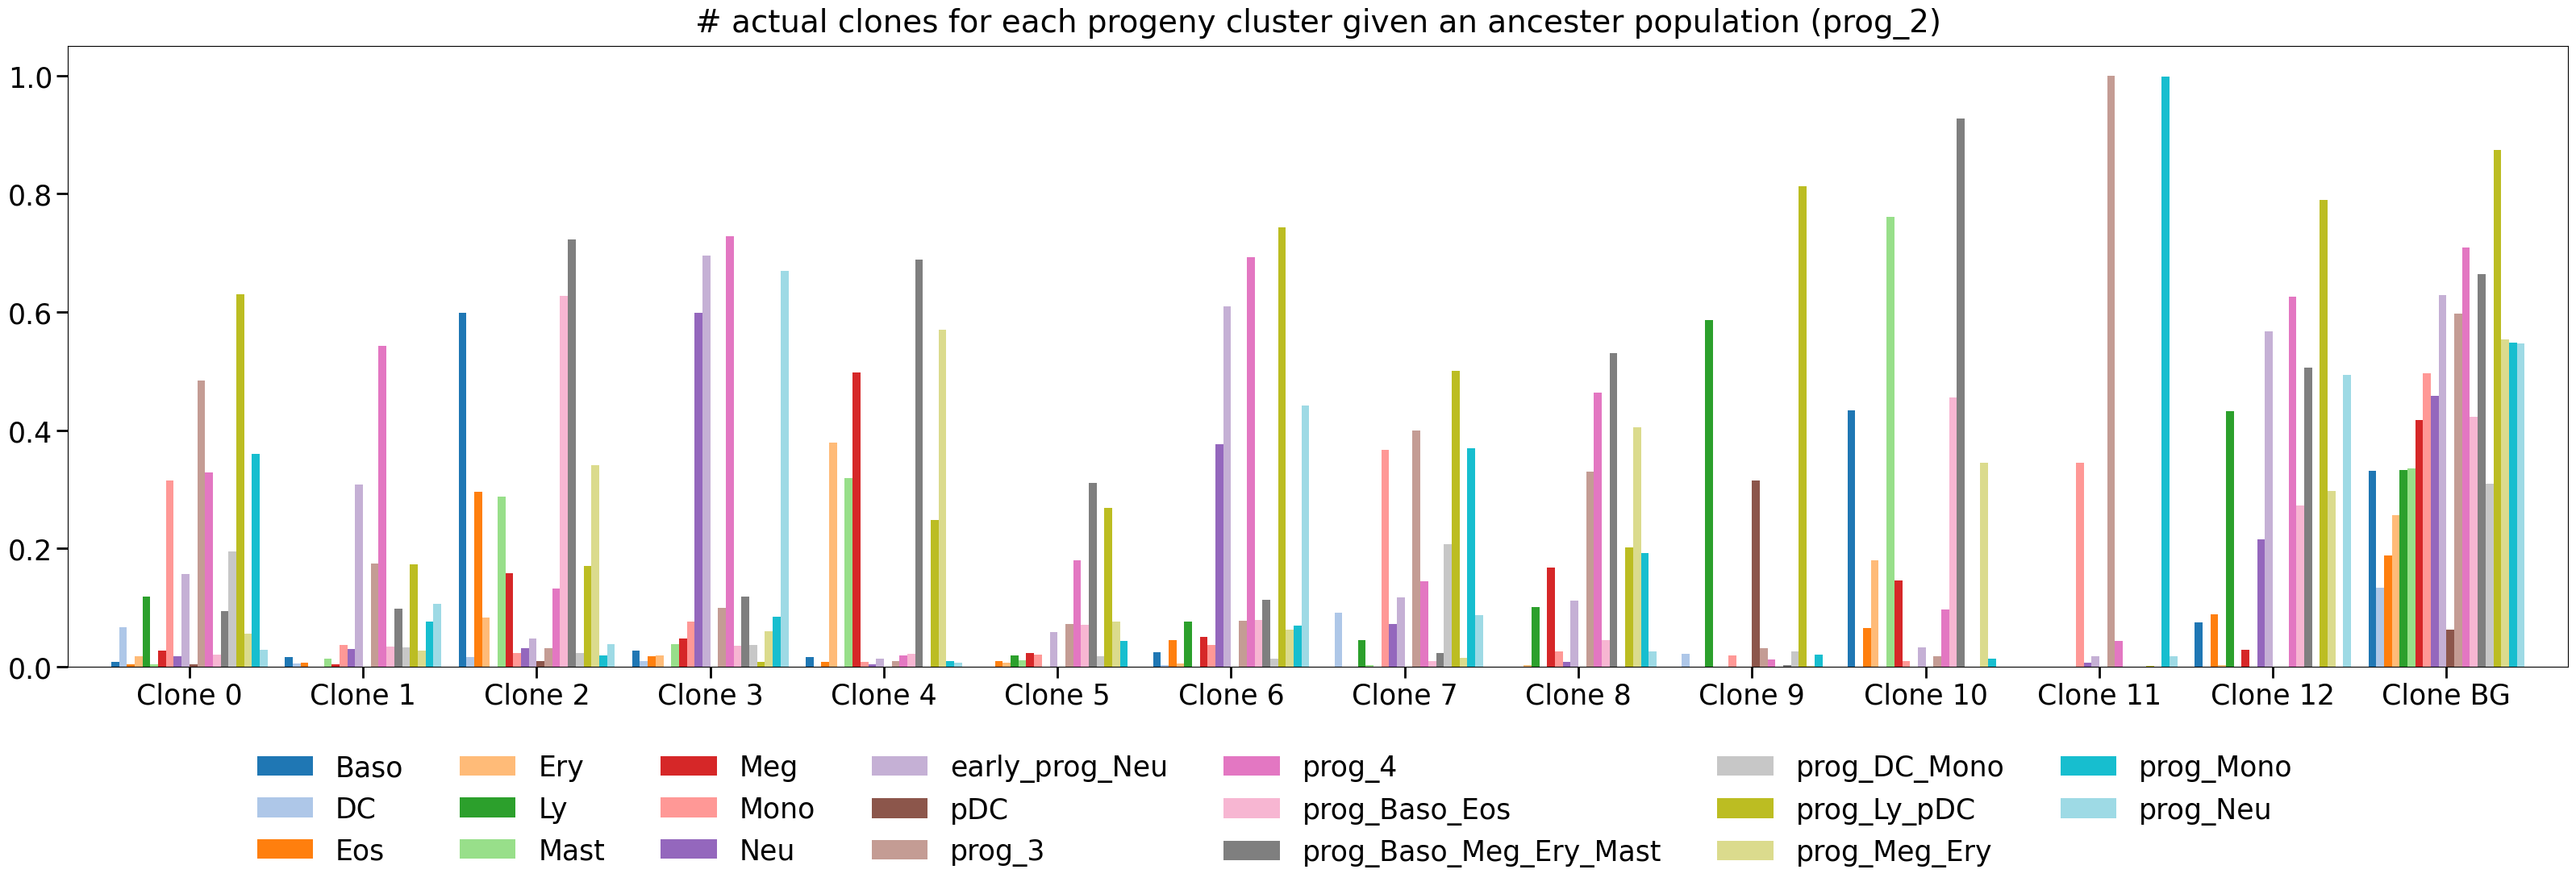

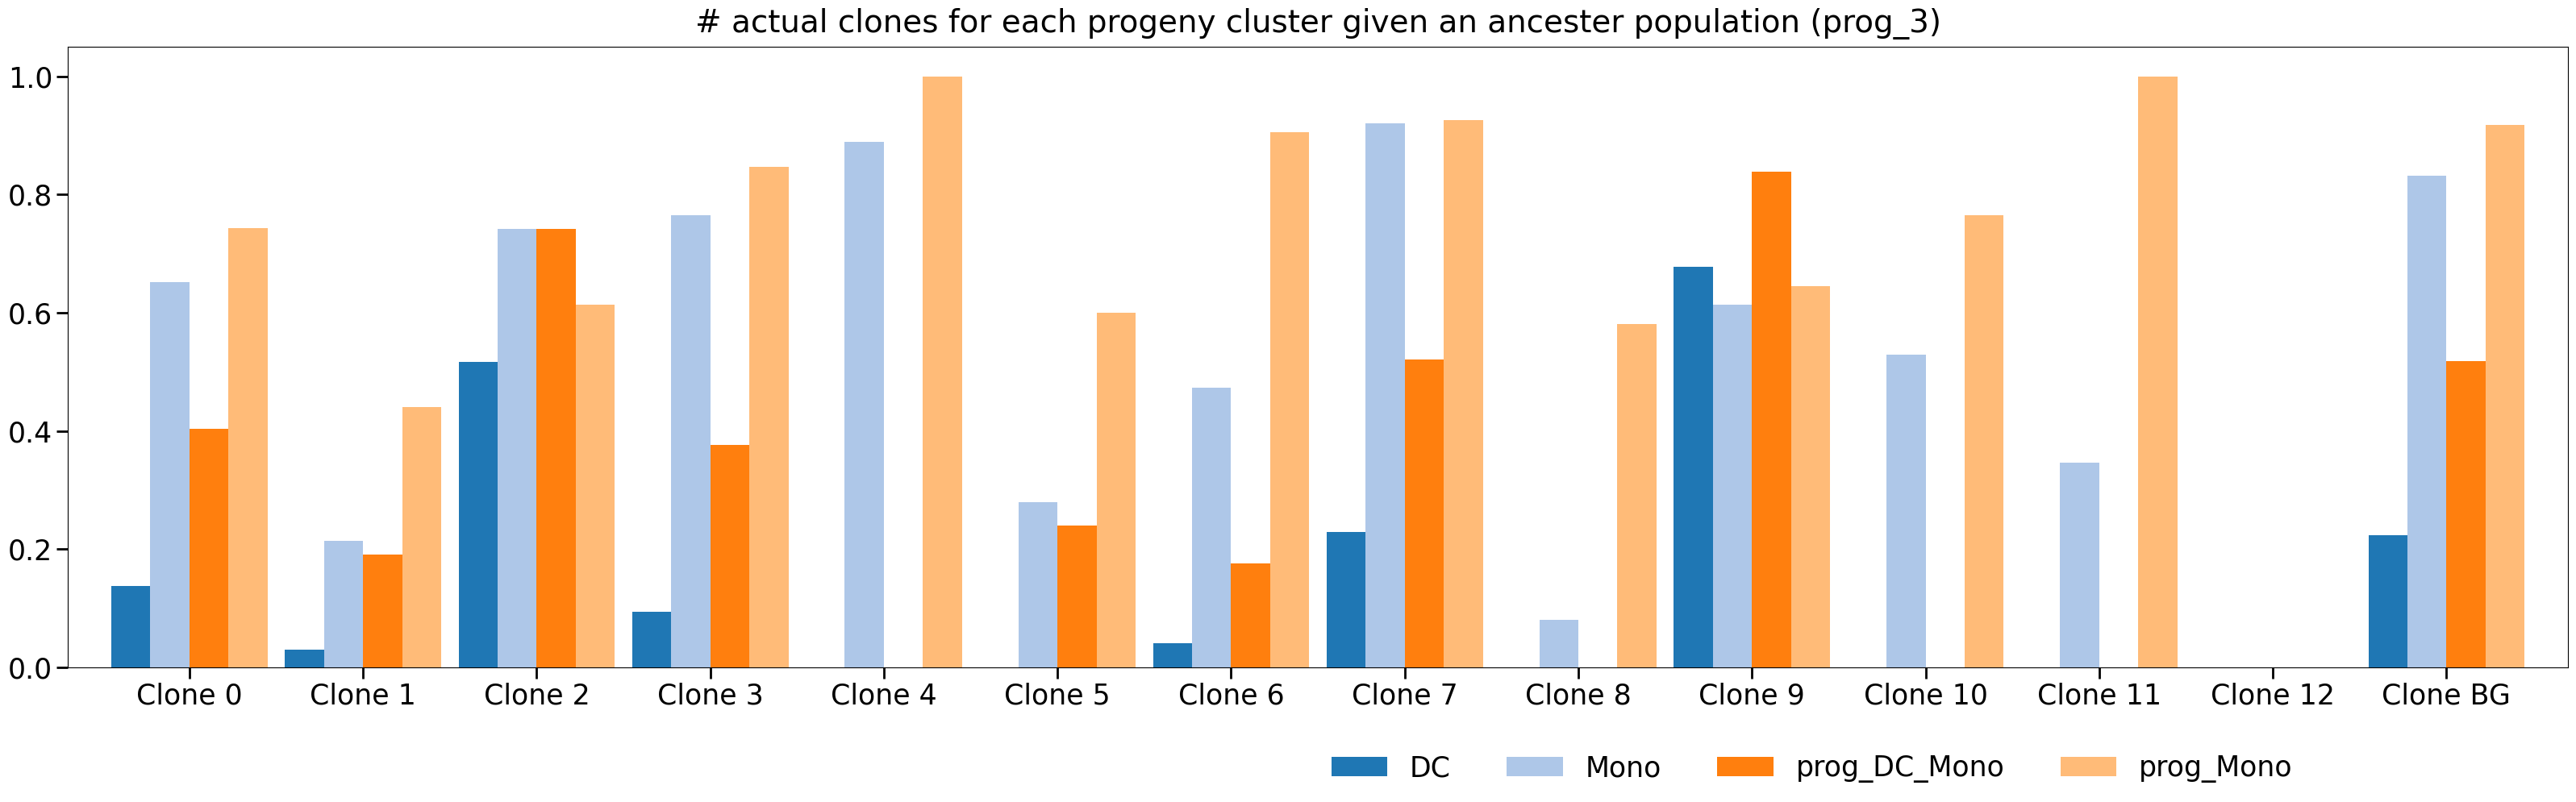

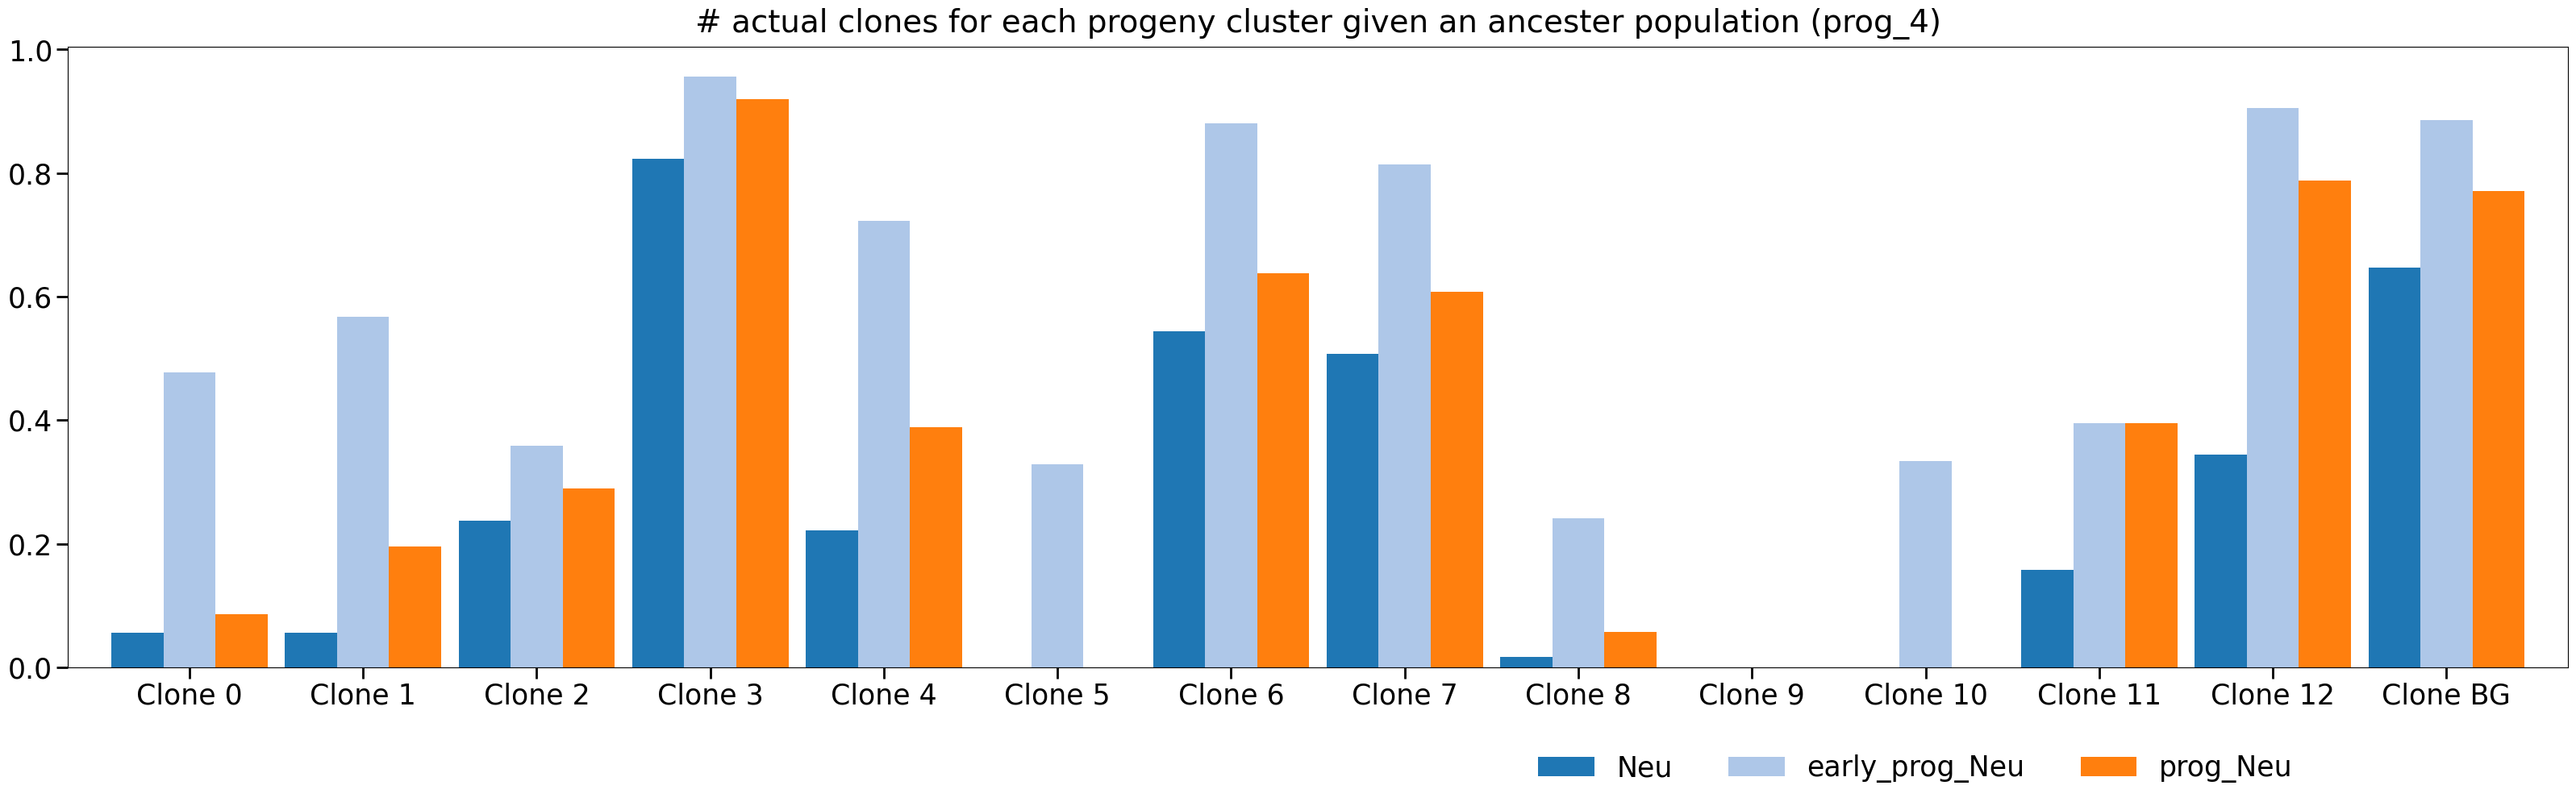

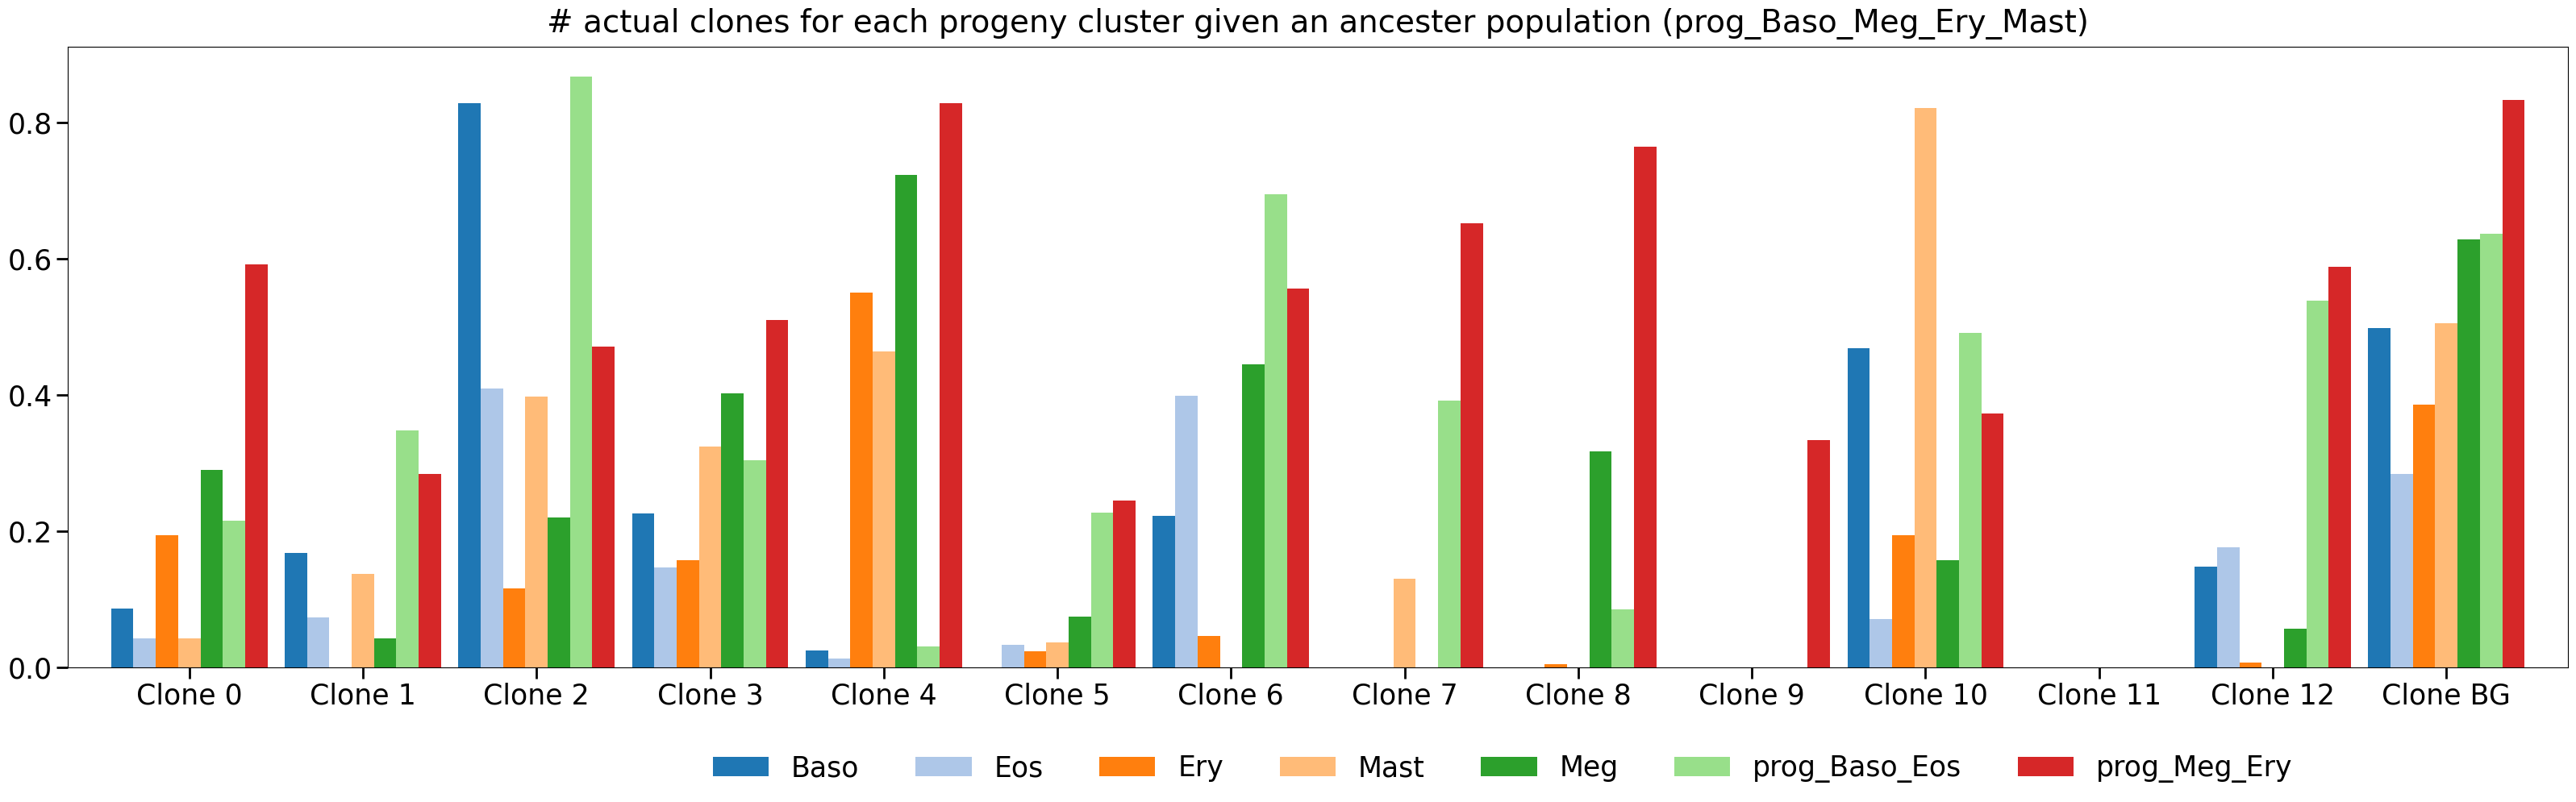

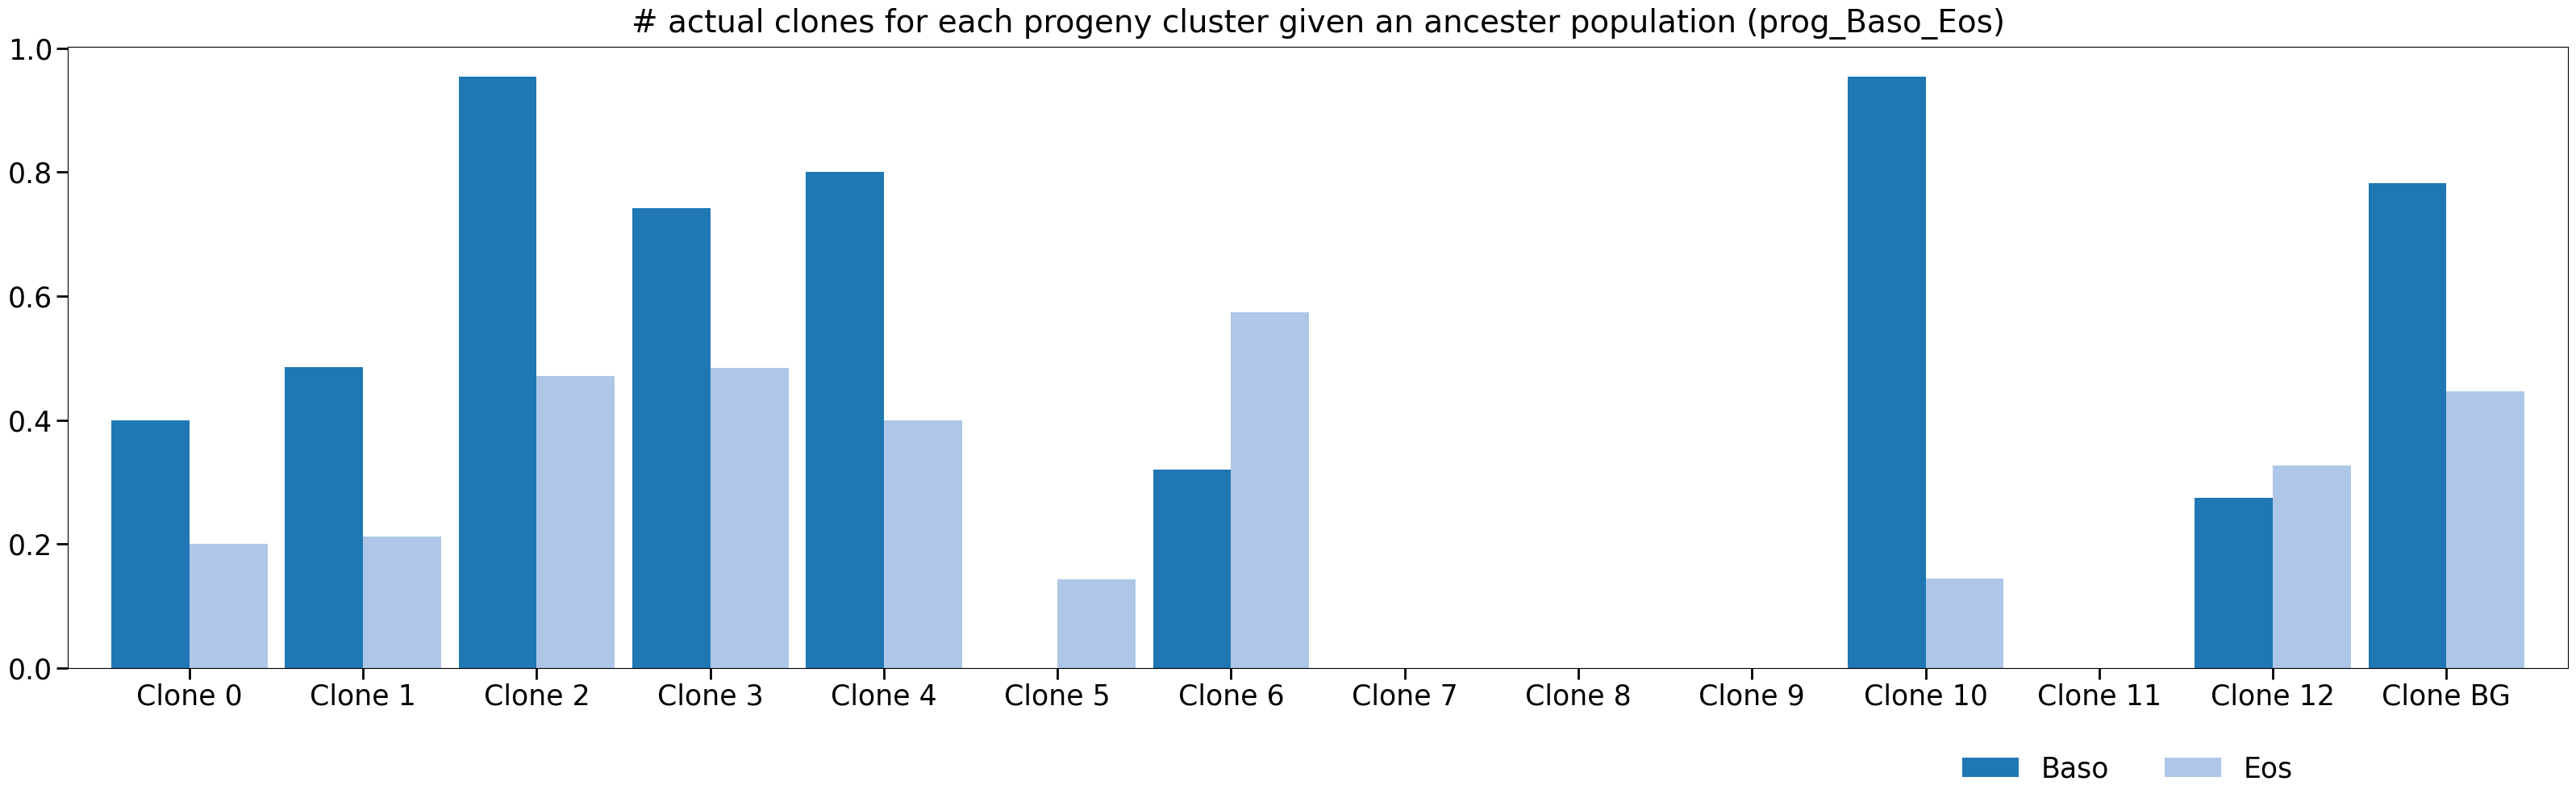

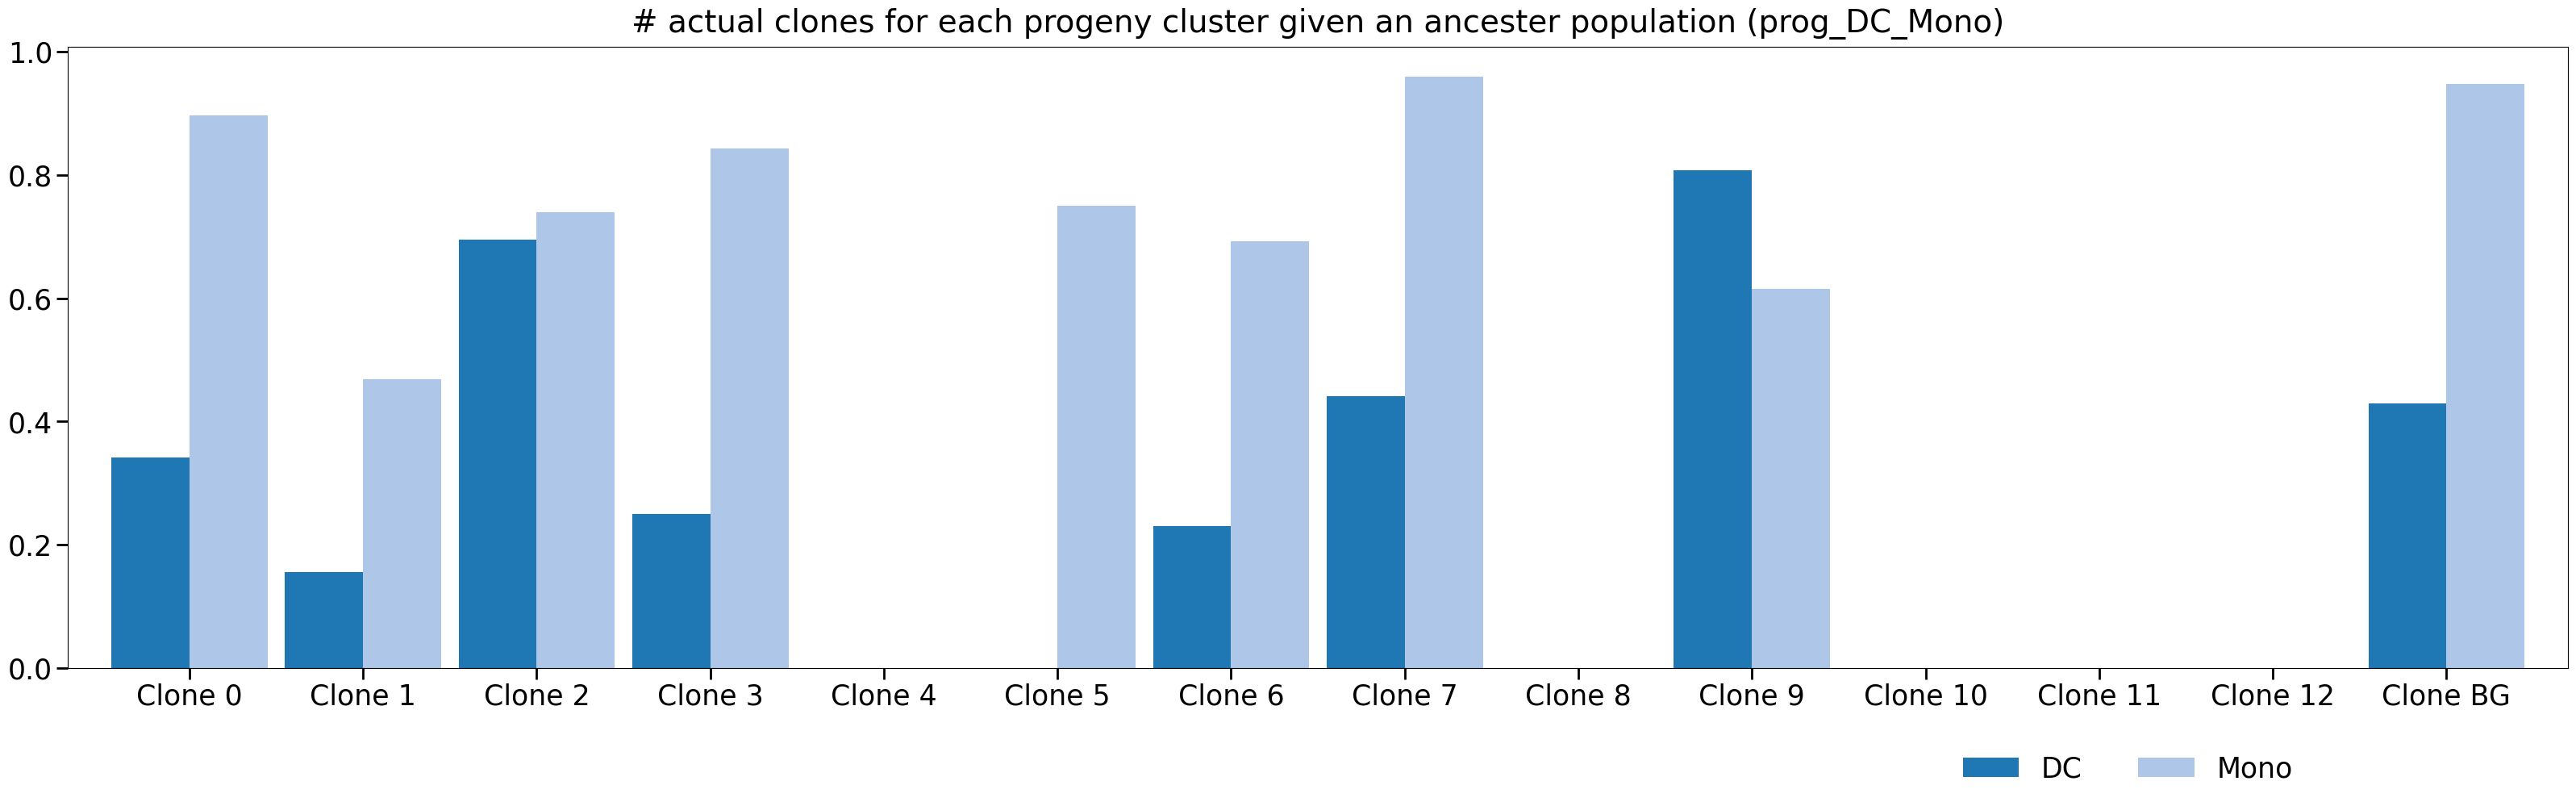

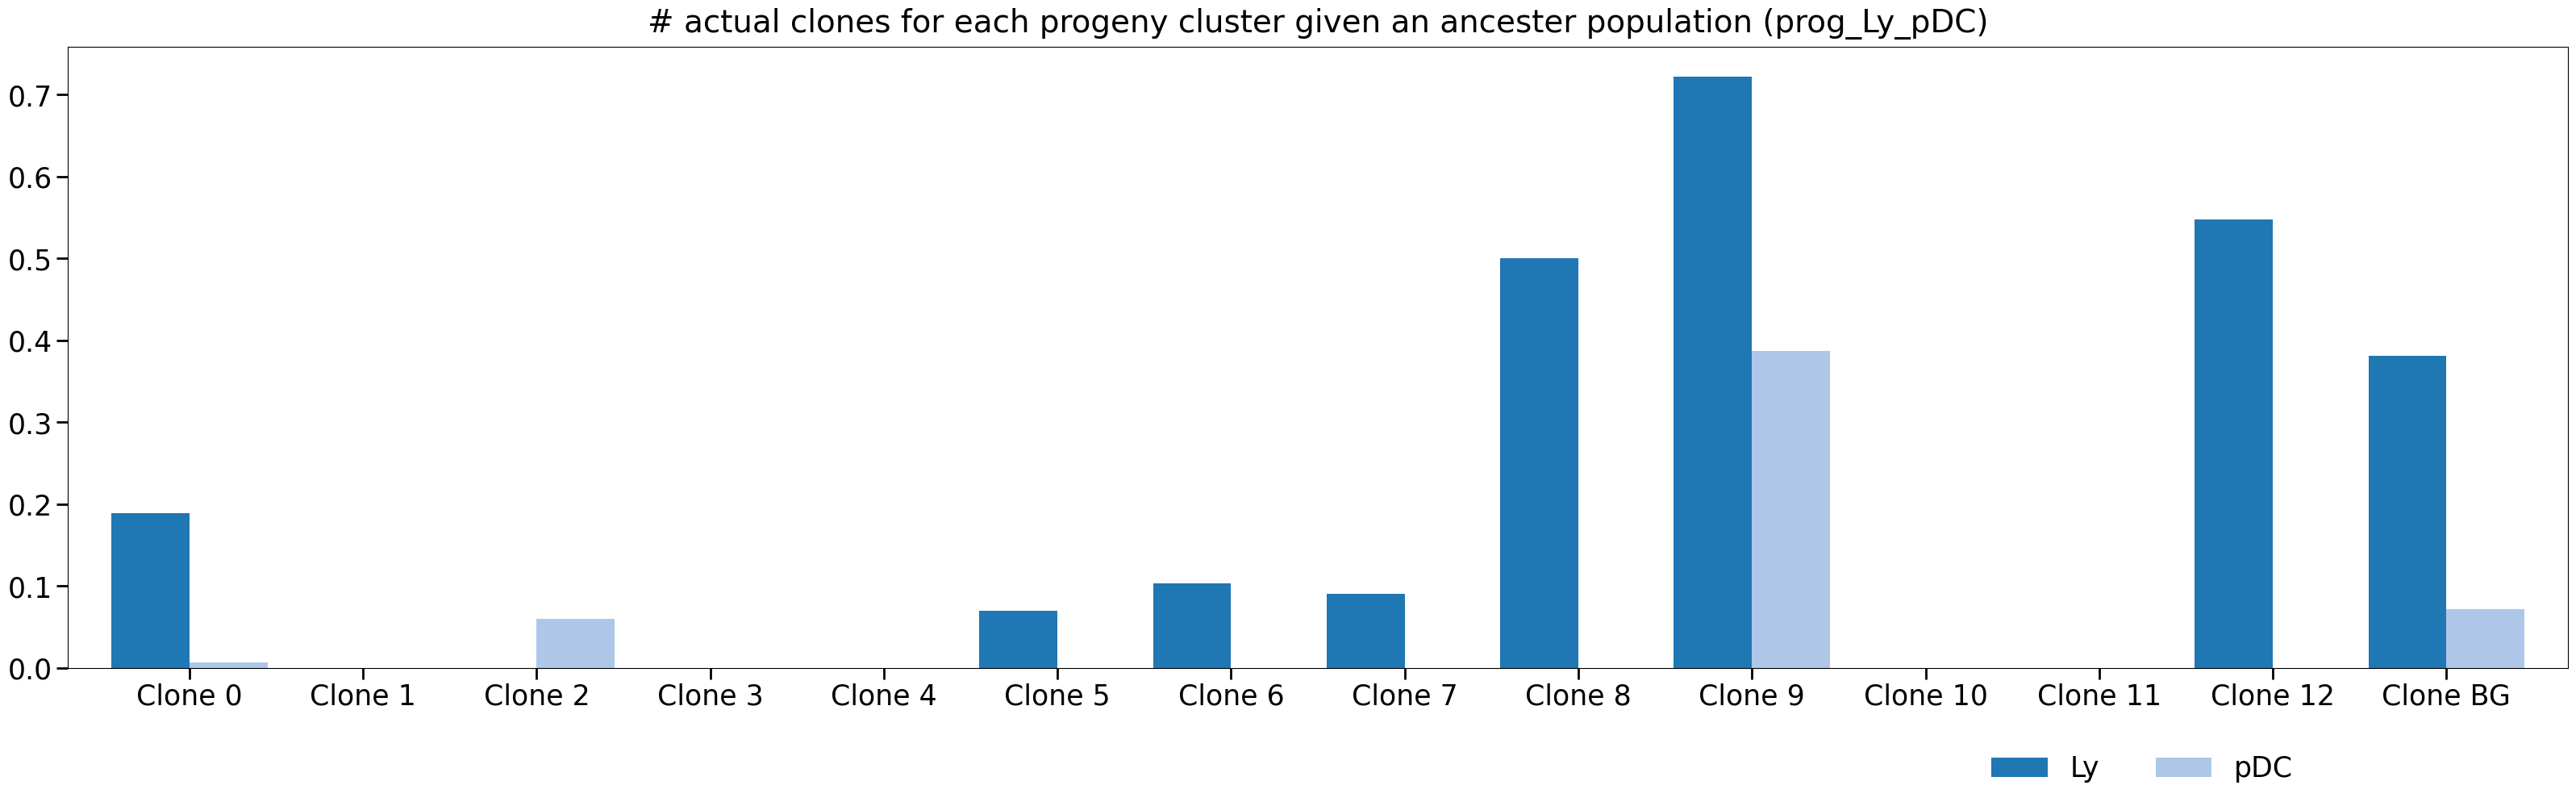

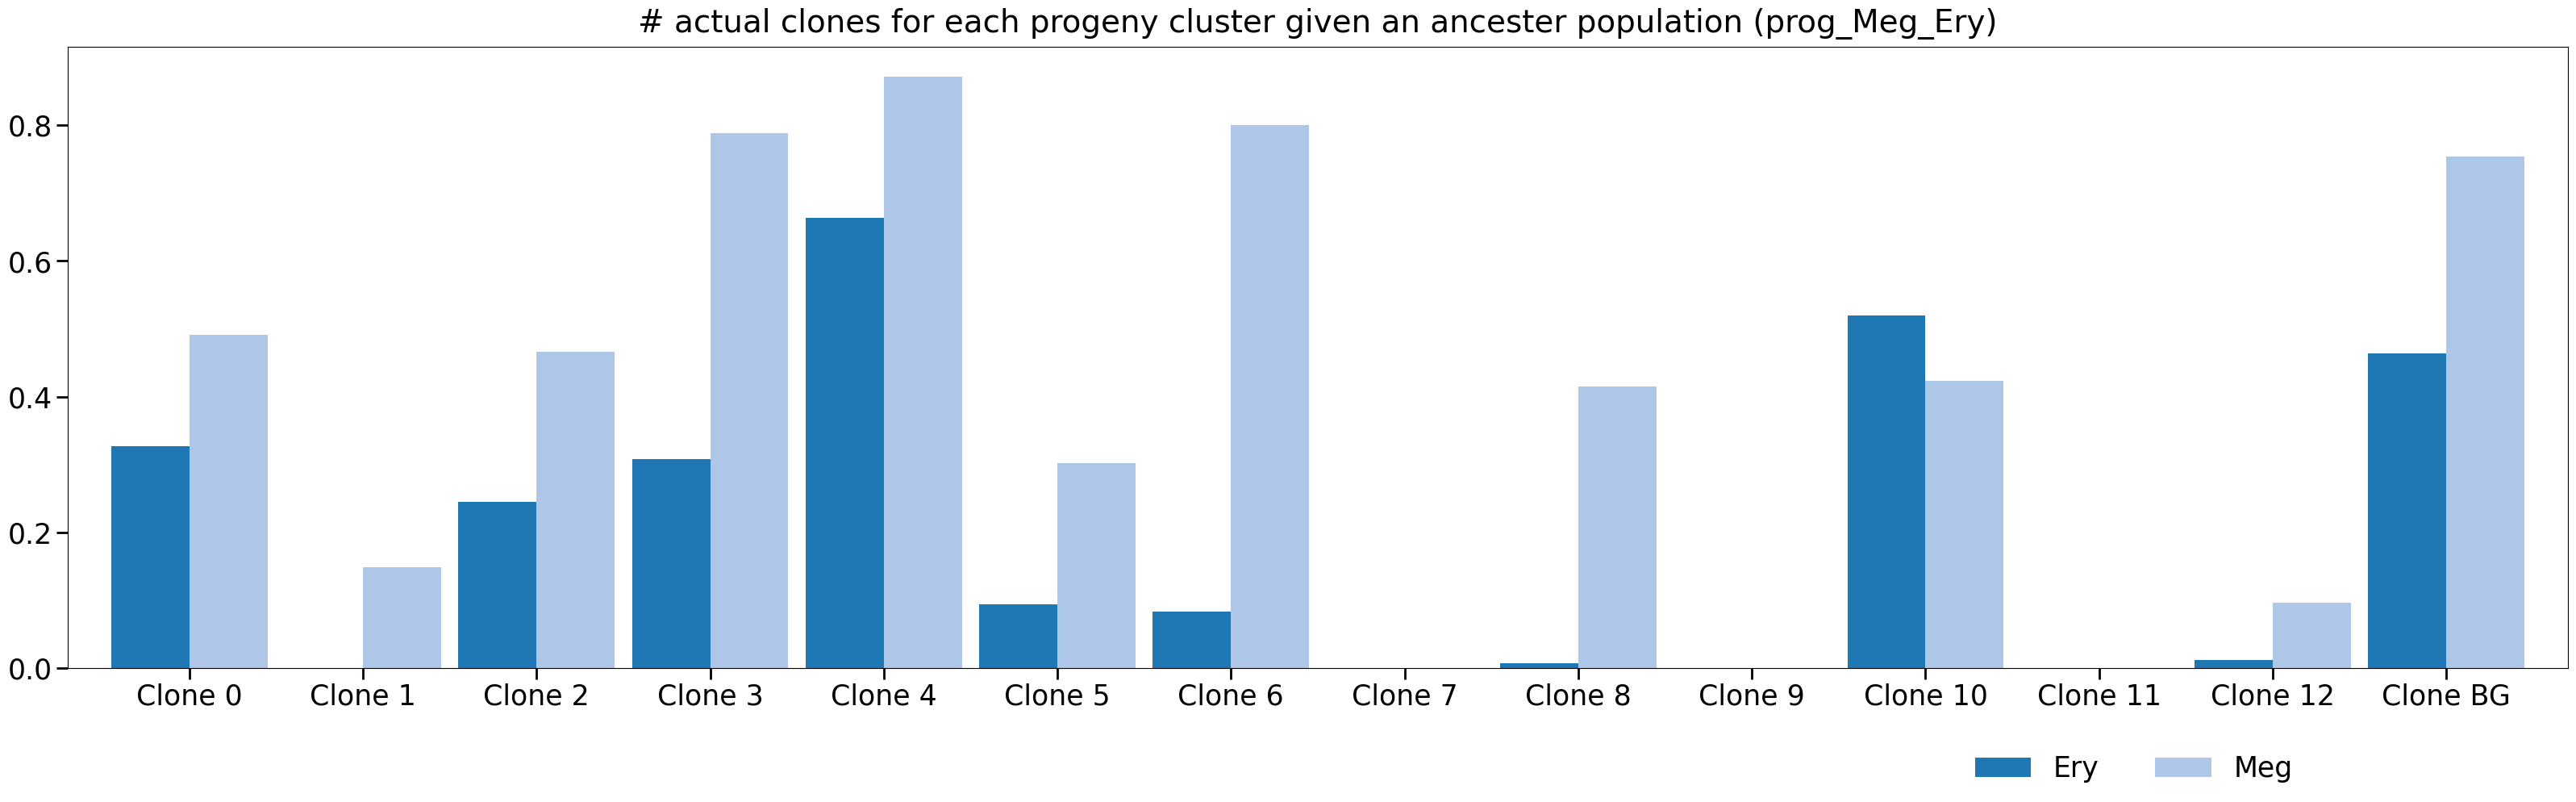

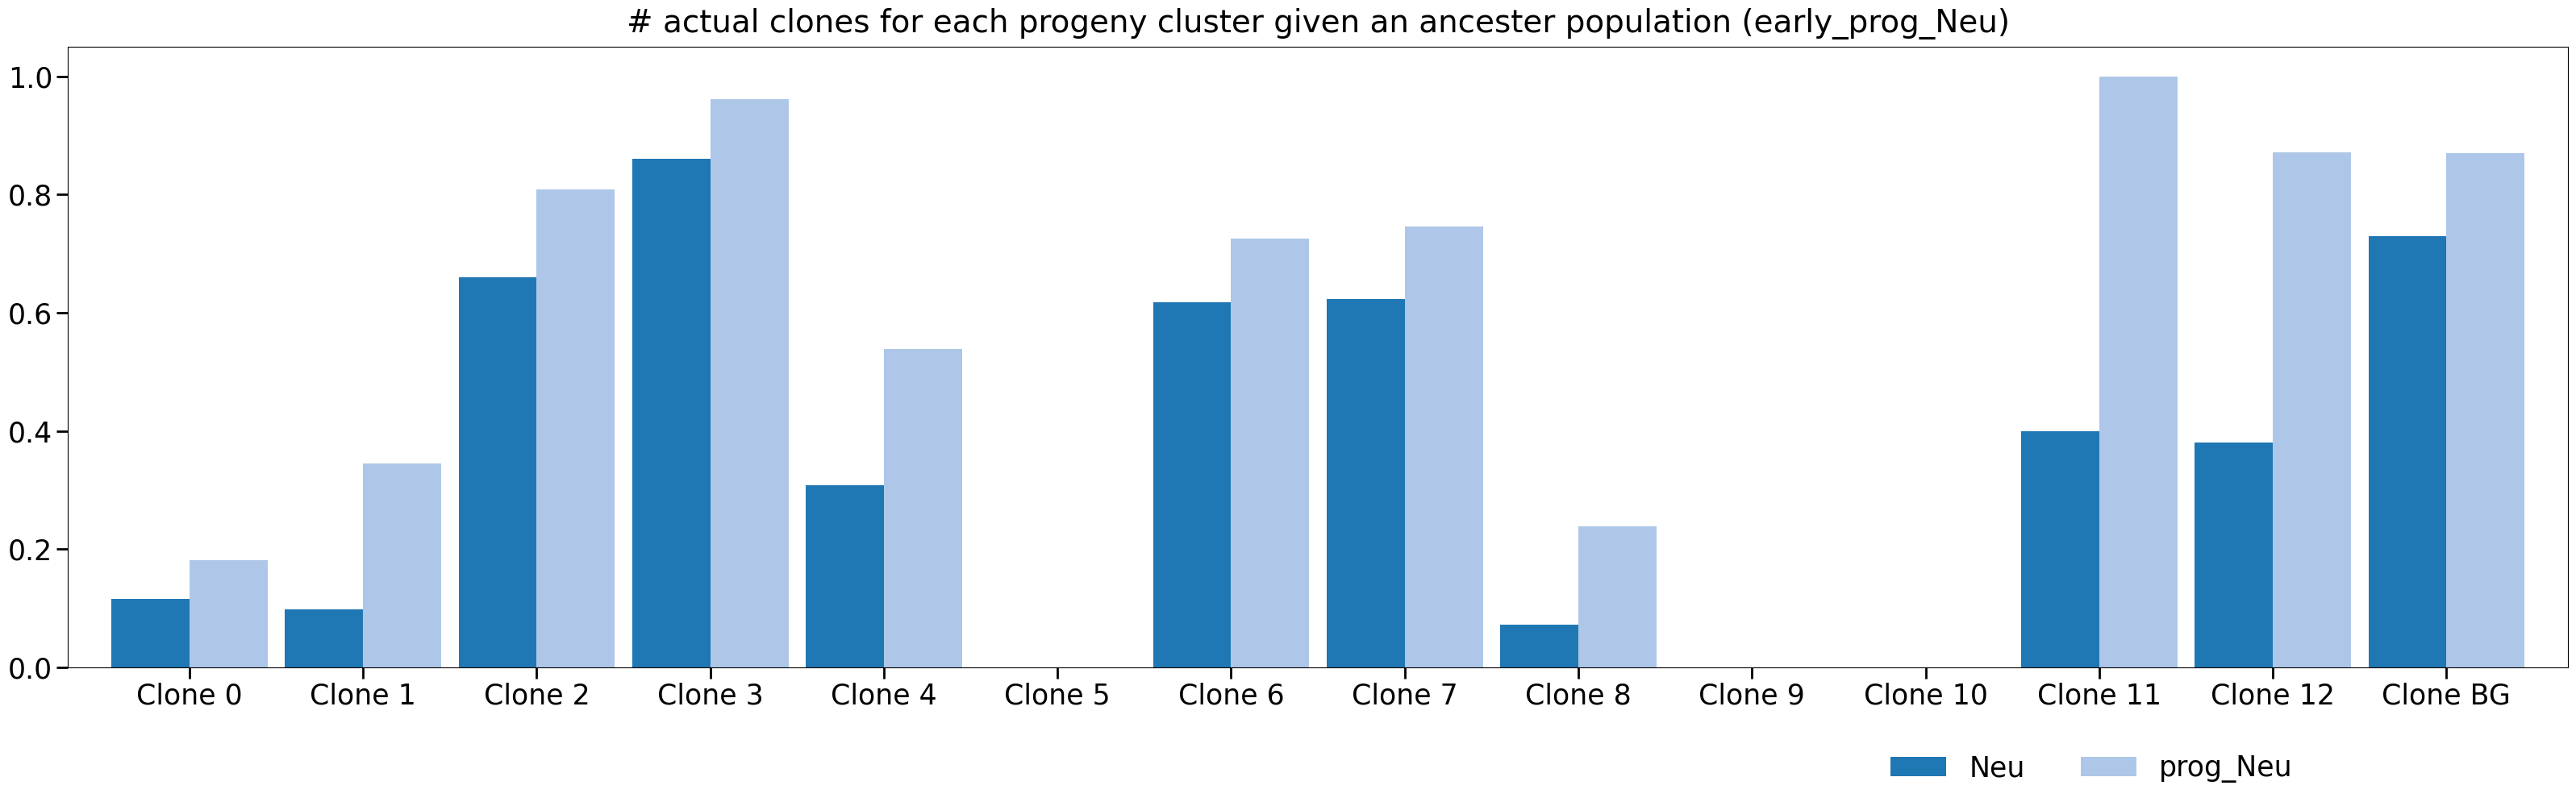

In [15]:
from clonaltrans.pl import pl_fate_prob
for label in cluster_names:
    pl_fate_prob(aggre, label)

#### Number of Actual Clones for each Progeny

In [16]:
import scanpy as sc
adata = sc.read_h5ad('./datasets/Weinreb/adata_used.h5ad')
adata

AnnData object with n_obs × n_vars = 44756 × 5000
    obs: 'Time_point', 'Population', 'Annotation', 'Well', 'time_cat', 'leiden', 'comb', 'label_man', 'clones', 'meta_clones'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Annotation_colors', 'Time_point_colors', 'comb_colors', 'hvg', 'label_man_colors', 'label_man_sizes', 'leiden', 'leiden_colors', 'log1p', 'meta_clones_colors', 'neighbors', 'paga', 'pca', 'time_cat_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [17]:
from clonaltrans.pl import get_fate_clones
aggre_clones = get_fate_clones(adata, aggre)

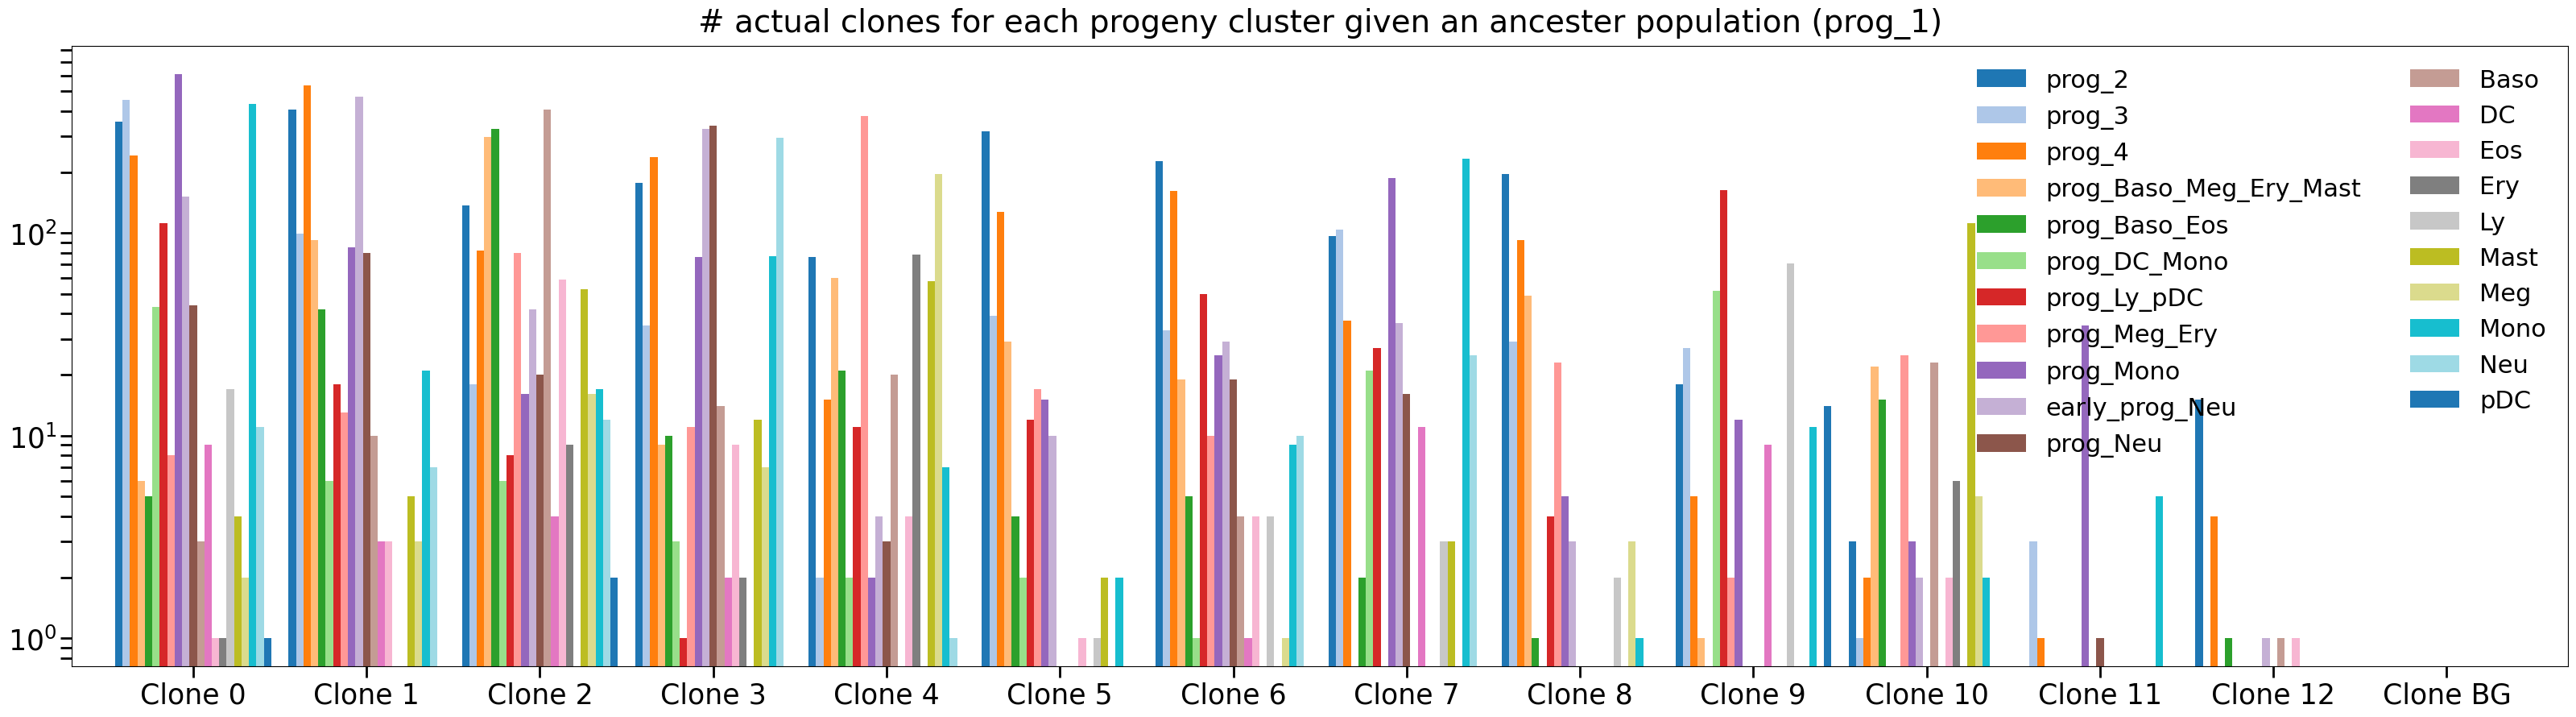

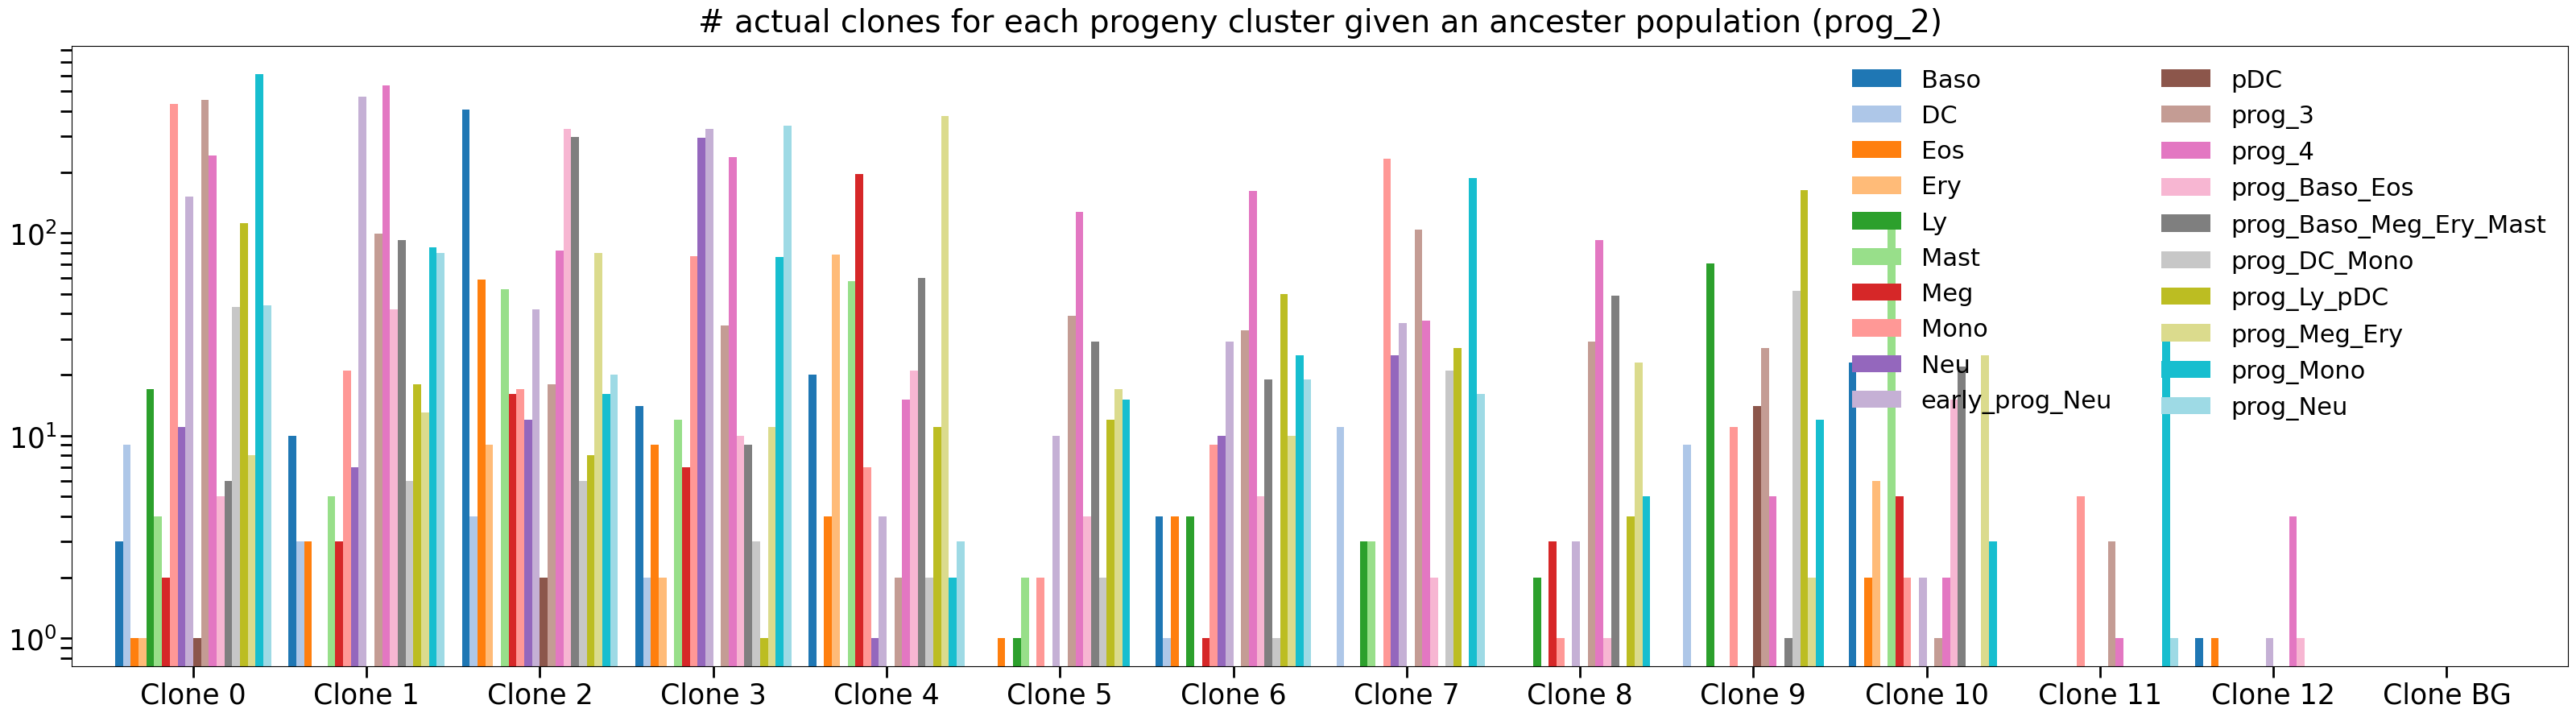

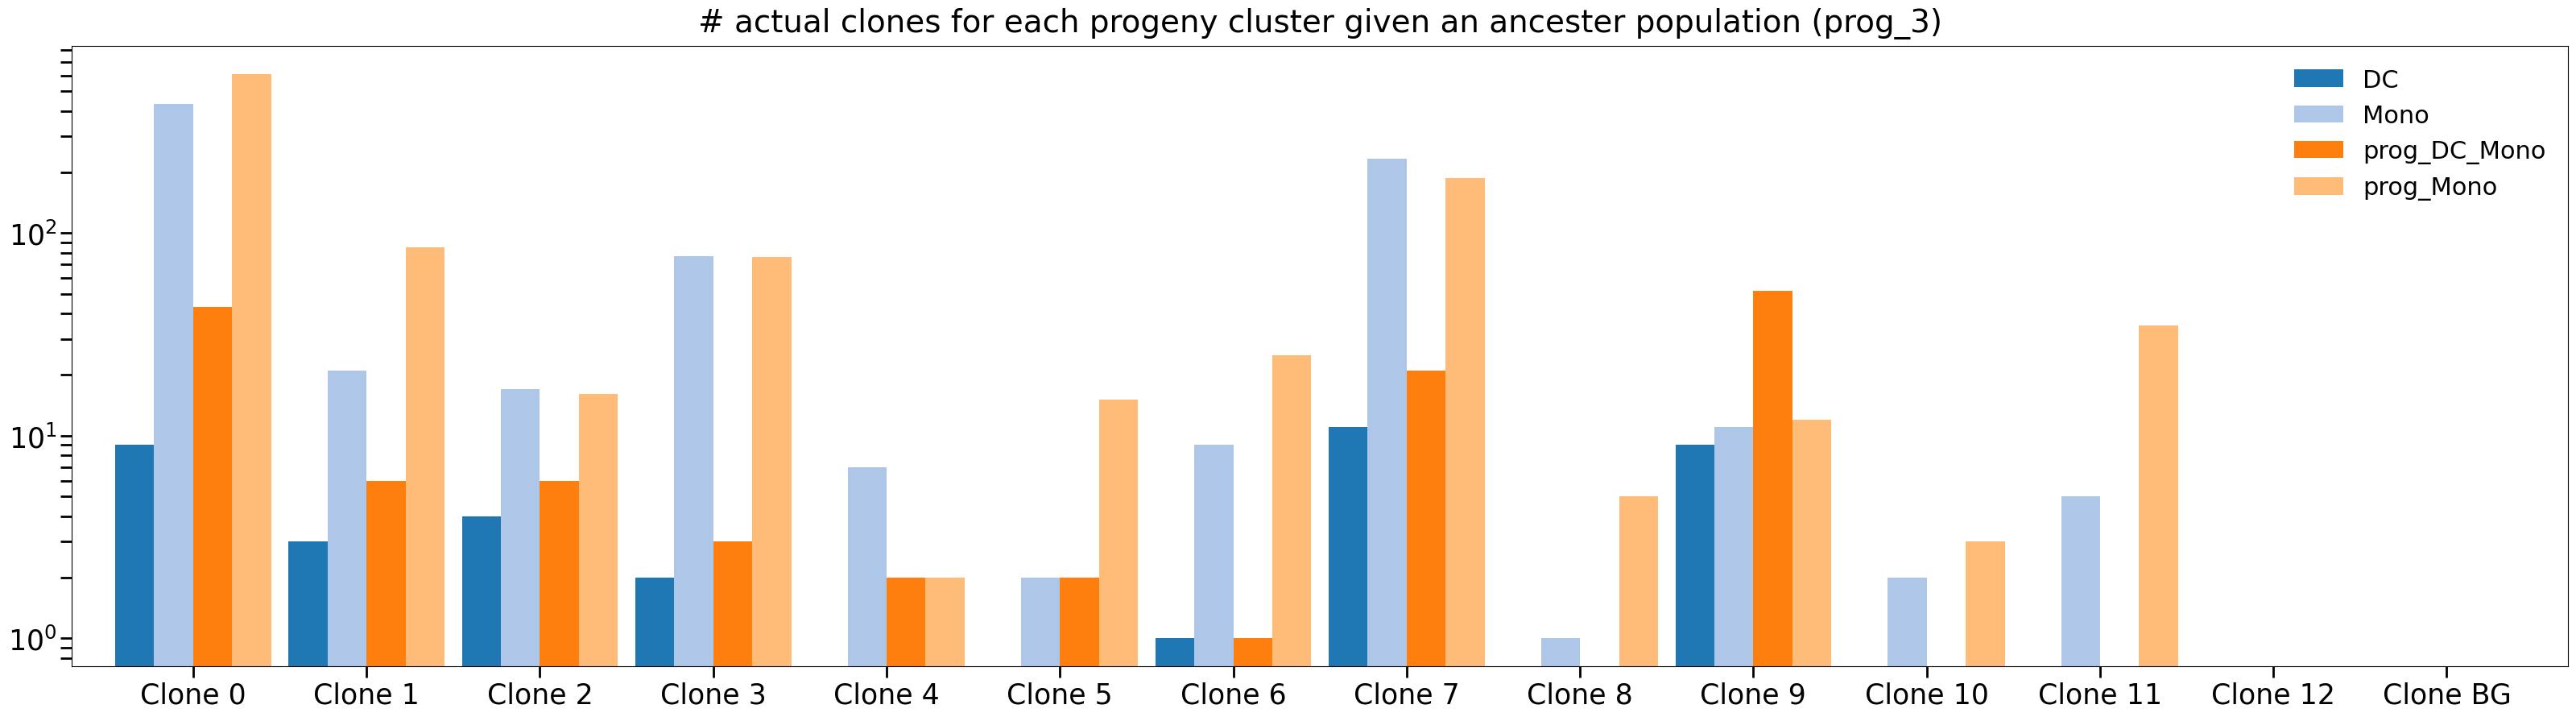

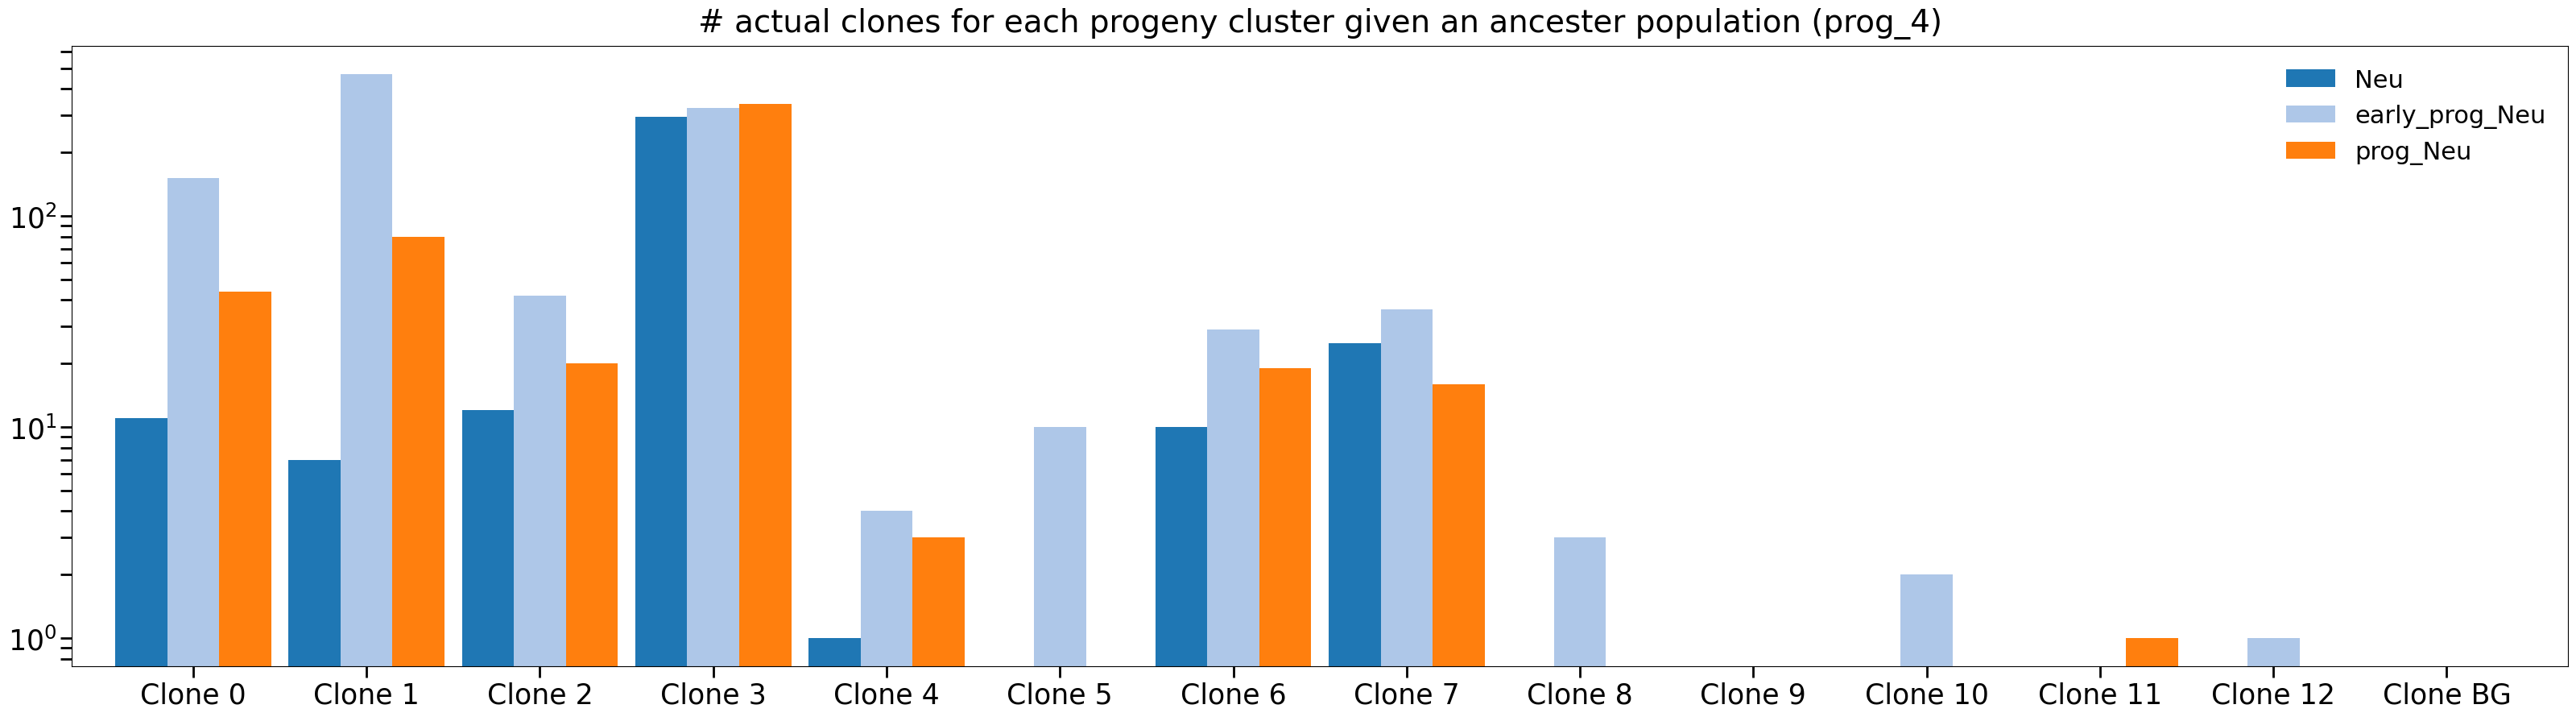

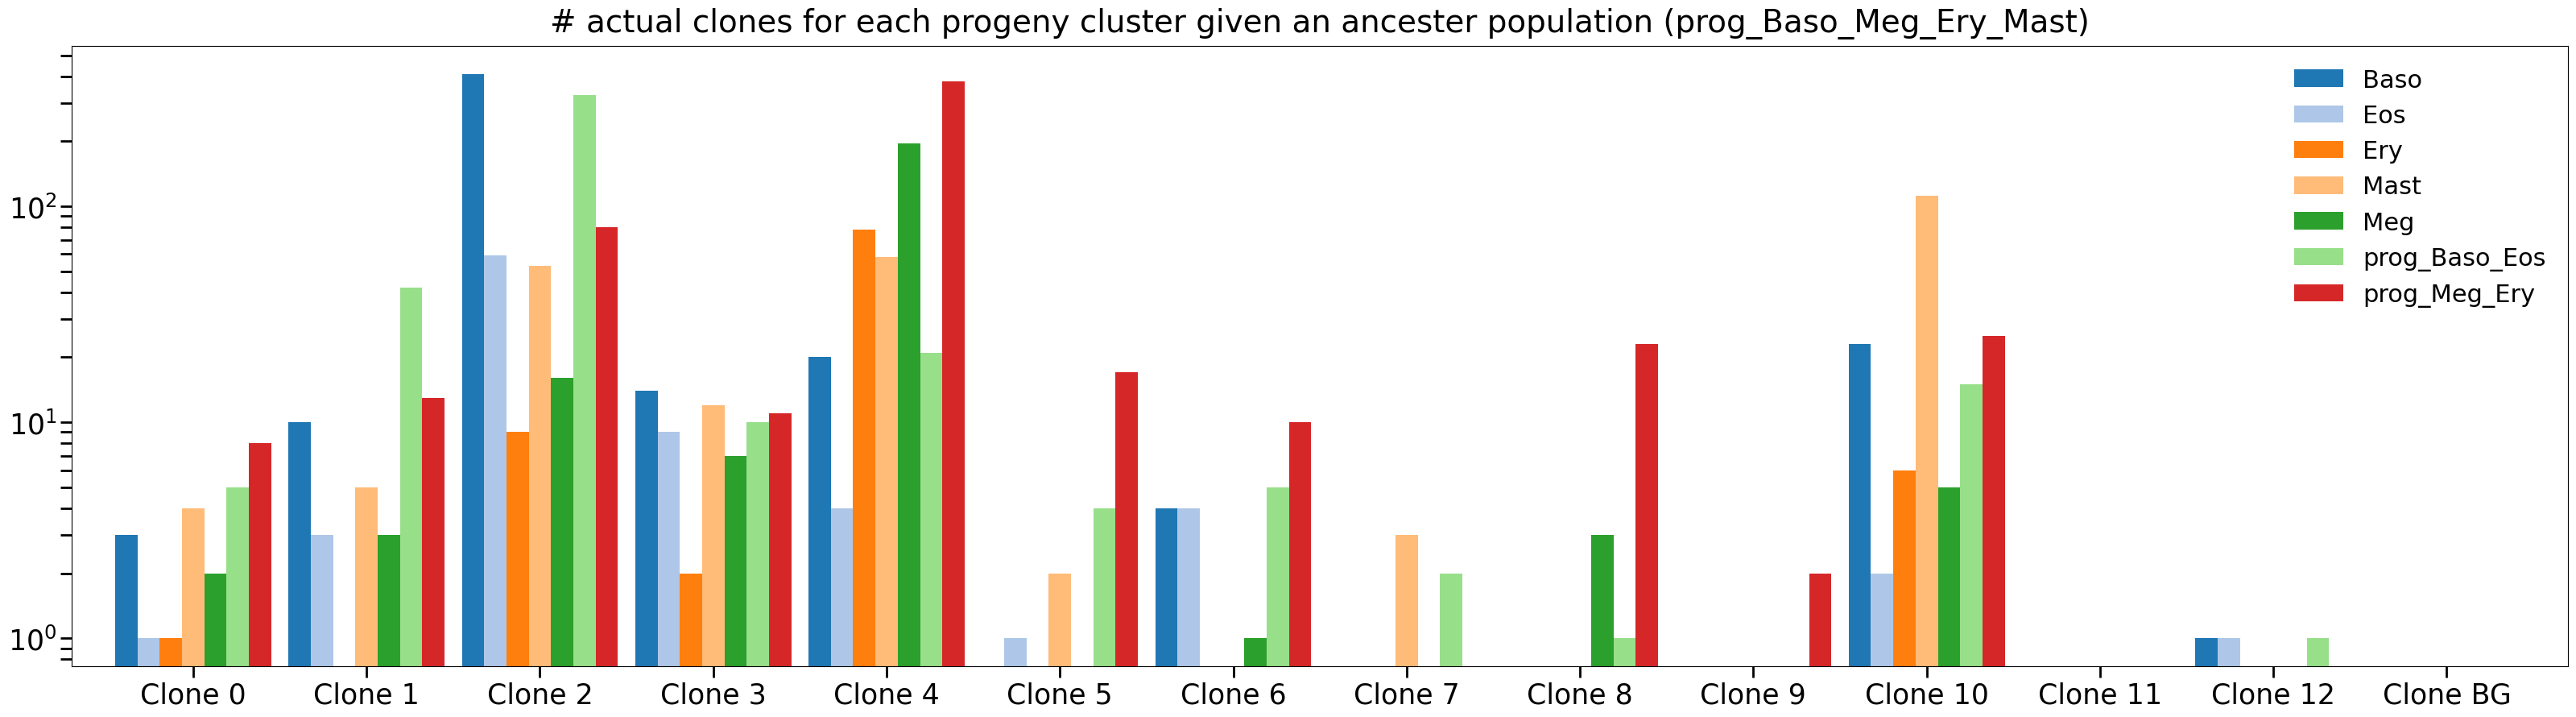

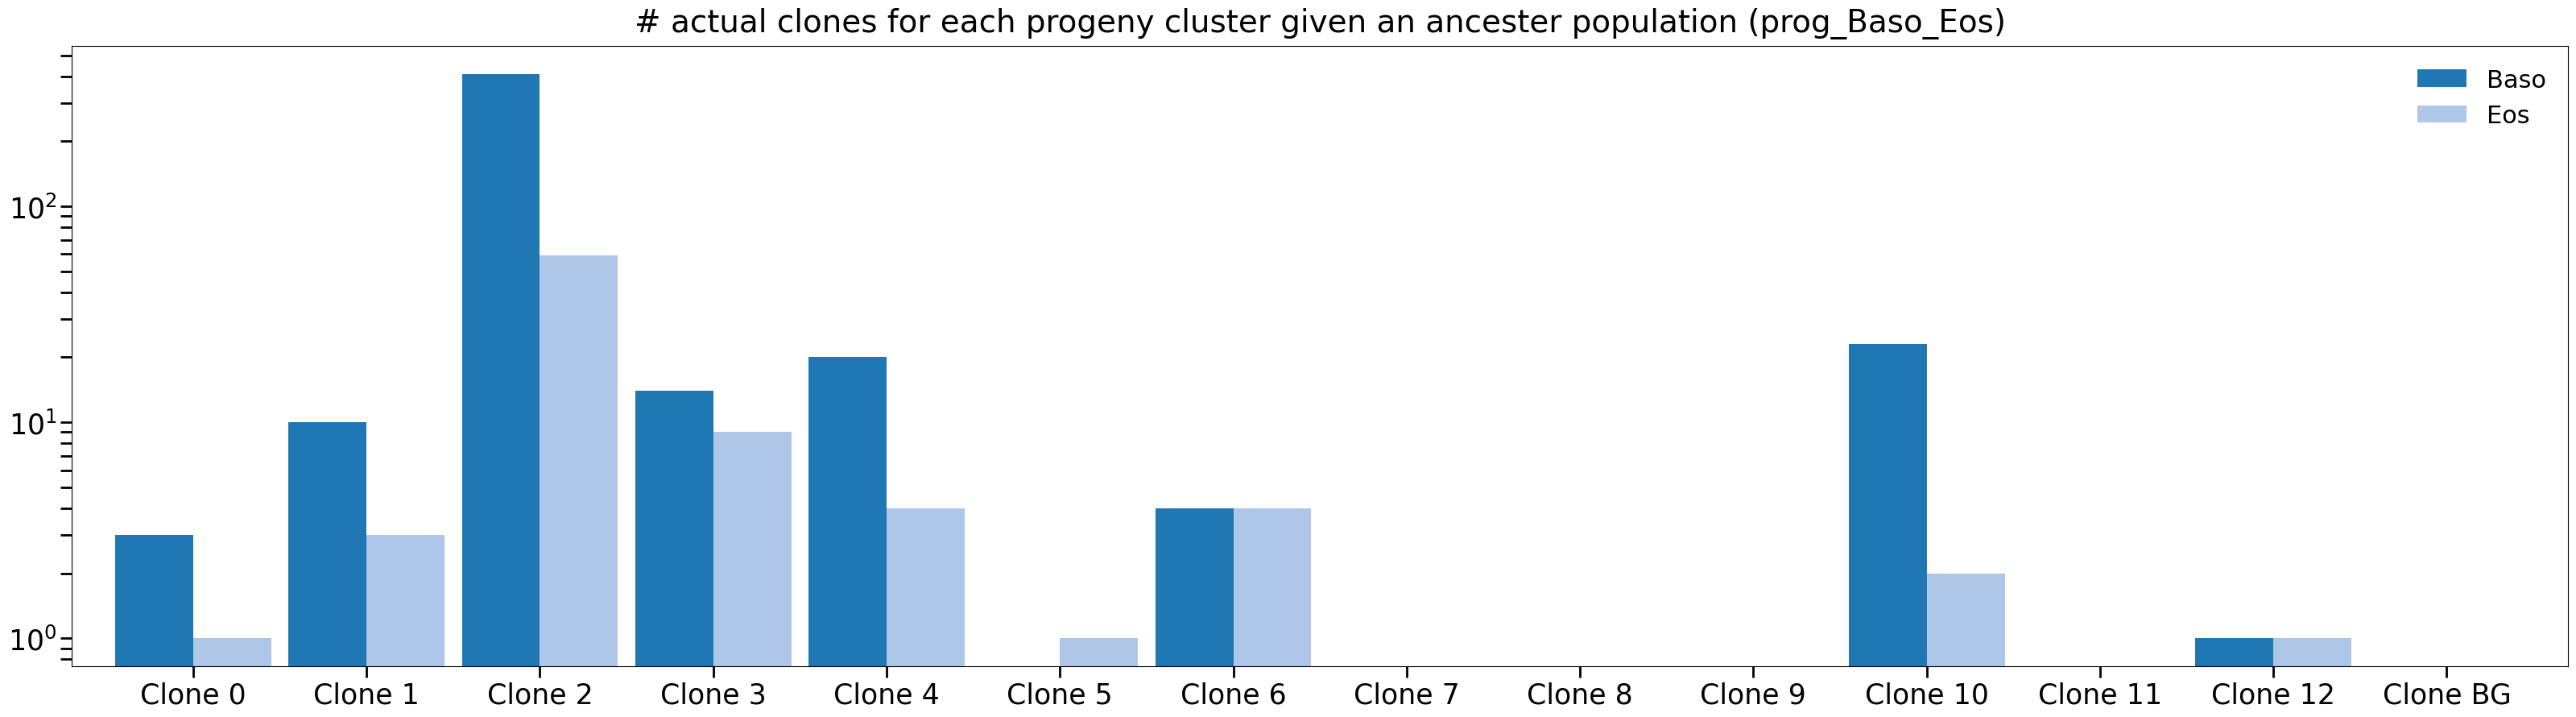

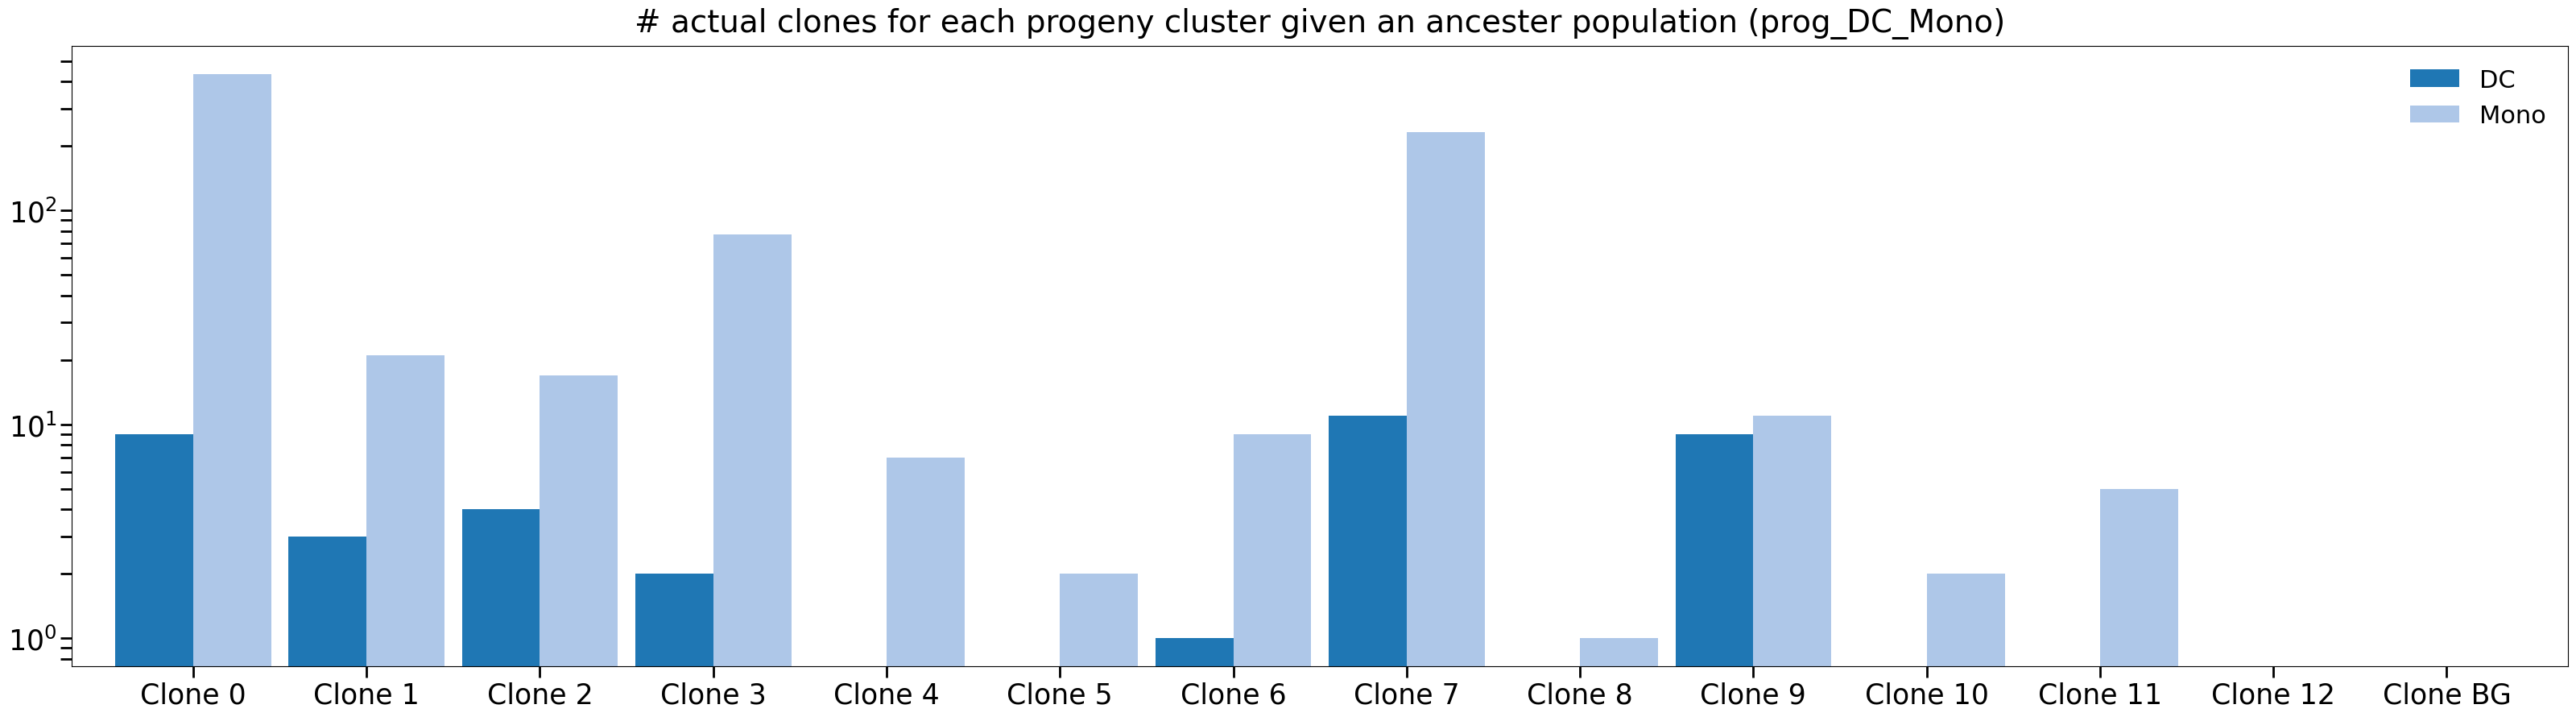

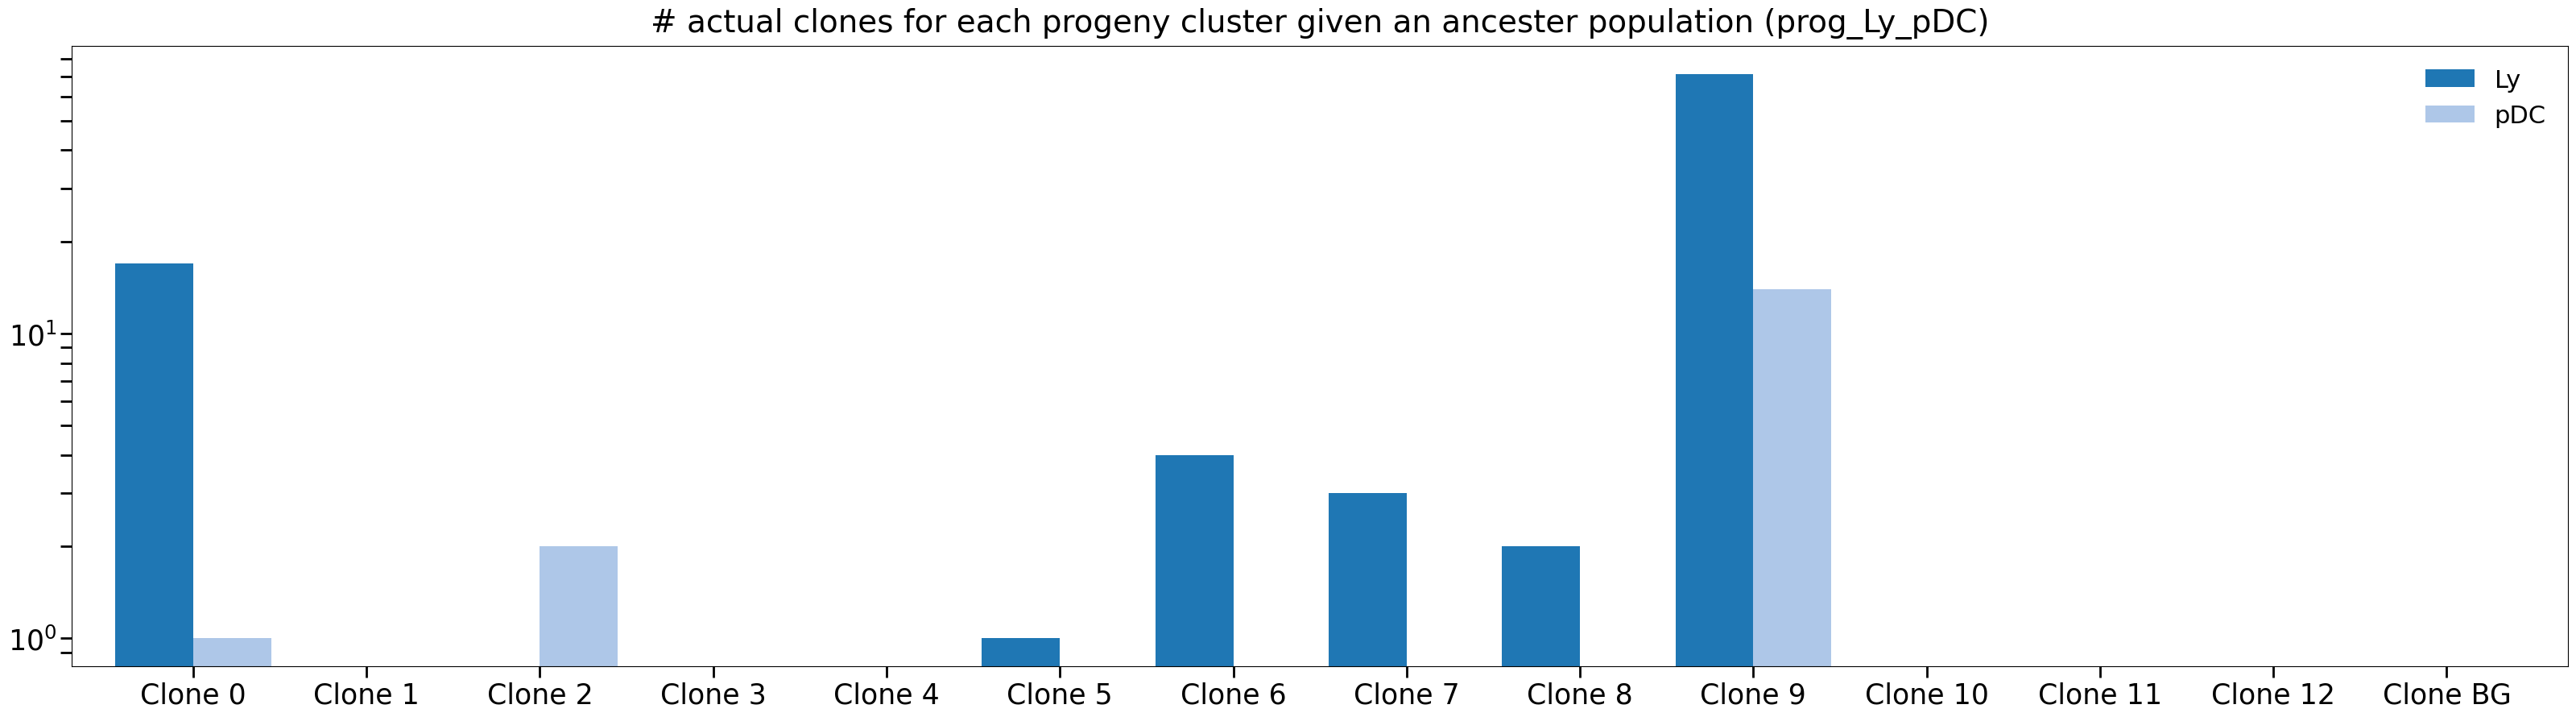

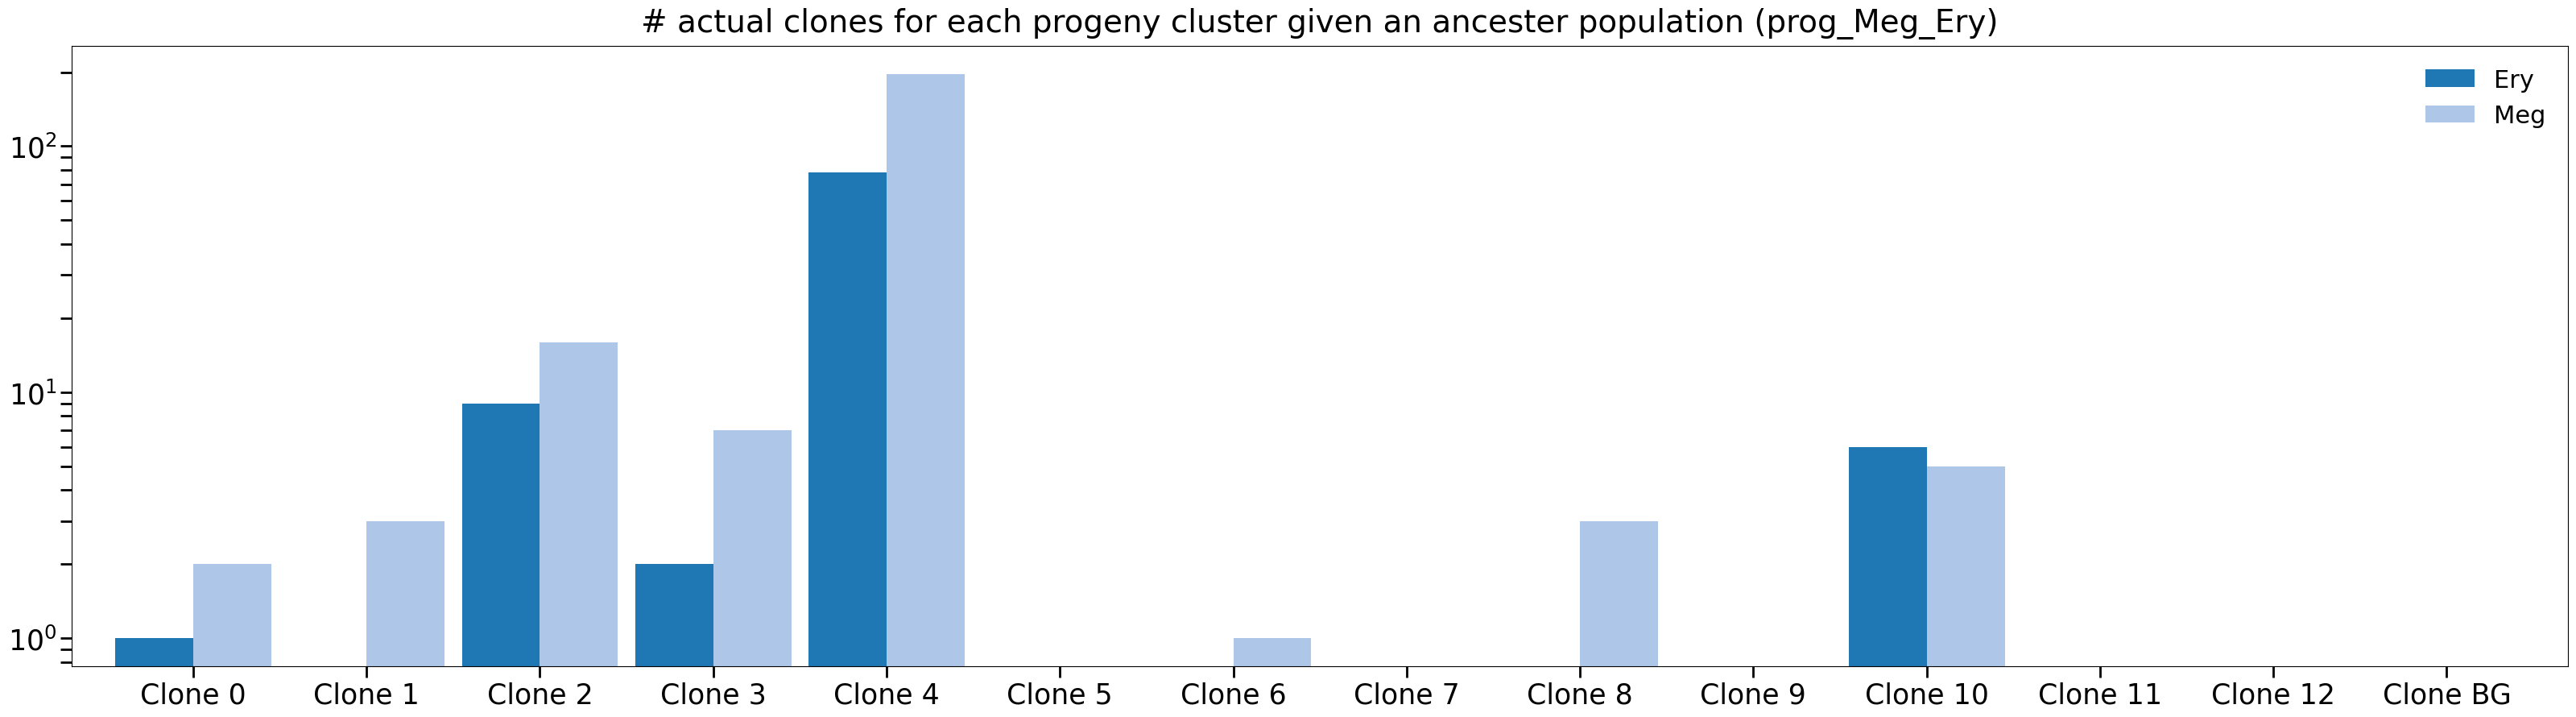

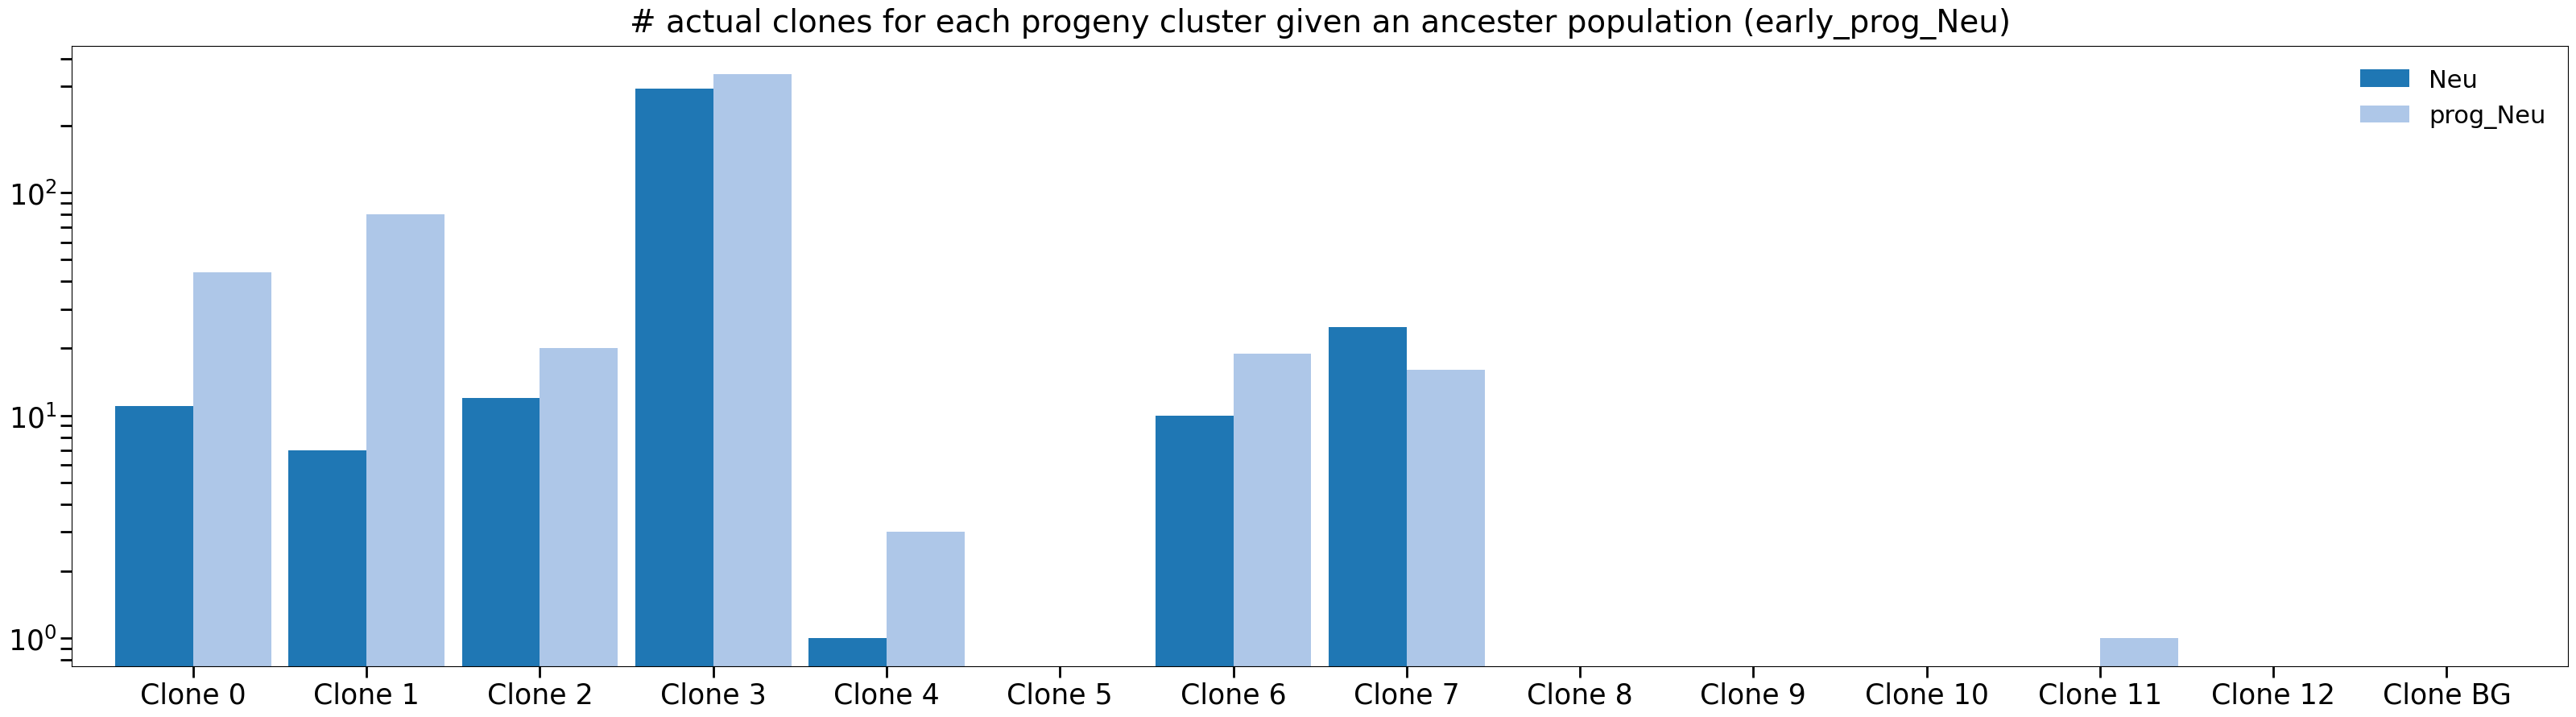

In [18]:
from clonaltrans.pl import pl_fate_prob
for label in cluster_names:
    pl_fate_prob(aggre_clones, label, logy=True)